# Прогнозирование поведения клиентов - домашняя работа

#### Импортируем нужные библиотеки

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive

#### Считываем данные

In [1]:
# df = pd.read_csv(
#     'seminar6_20181025.csv',
#     sep=";",
#     encoding= "cp1251",
#     date_parser=lambda x: pd.to_datetime(x, format='%d%b%Y'), #преобразуем даты
#     parse_dates=['generation_month']
# )
# df['generation_month'] = pd.to_datetime(df['generation_month'])
# df.head(10)

## Построим винтажи кривых оттока - attrition ratio и attrition rate

#### Выгружаем таблицу

In [2]:
# # Выгружаем таблицу с винтажами

# atr_ratio_data = df.groupby(["generation_month", "statement_num"])\
#         .agg({"atr_flg":np.mean})\
#         .rename(columns = {"atr_flg": 'attrition_ratio'})\
#         .unstack('generation_month')
# atr_ratio_data

#### Задание 1
* Построить винтажи кривой attrition ratio (***1 балл***)

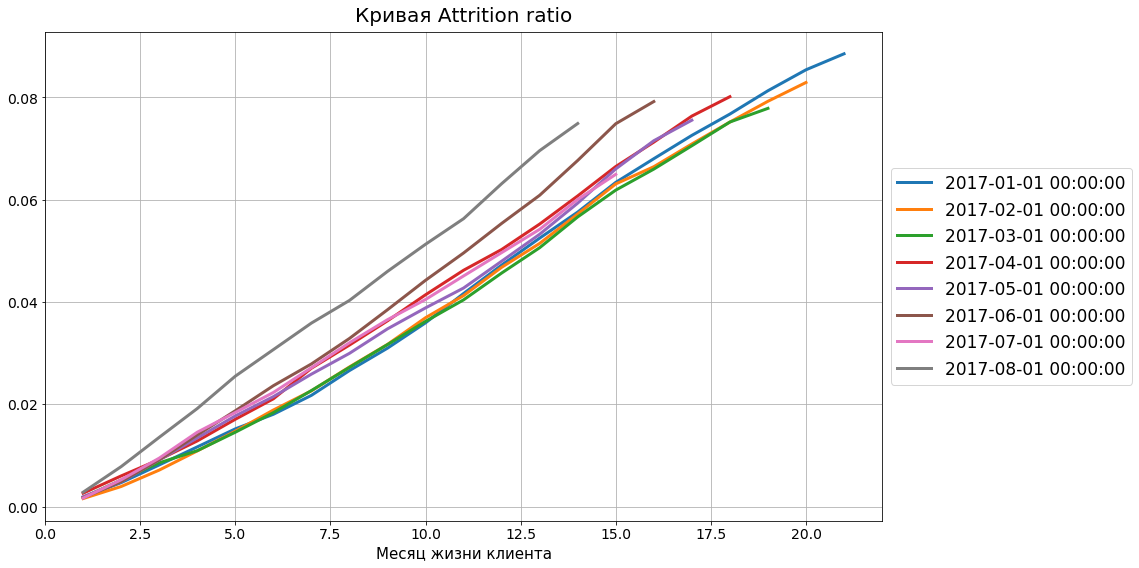

In [4]:
def plot_attrition_ratio_by_generation(df):
# Your code goes here
    return (df.groupby(["generation_month", "statement_num"])
            .agg({"atr_flg":np.mean})
            .rename(columns = {"atr_flg": 'attrition_ratio'})
            .unstack('generation_month')
            ['attrition_ratio']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))

# Строим график при помощи pyplot
plot_attrition_ratio_by_generation(df)

# Настраиваем параметры отображения графика
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Задание 2
* Построить винтажи кривой $$\text{Attrition rate}_n =  \frac{\text{#New ATR}_n}{\text{ACT}_{n-1}} = \frac{\text{#New ATR}_n}{\text{#TOTAL}_{n-1} - \text{ATR}_{n-1} - \text{DEF}_{n-1}}$$ (***1 балл***)

    Обратите внимание, что из знаменателя исключаются клиенты в дефолте, а для первого месяца attrition rate = attrition ratio 
* Объяснить форму построенных винтажей (***2 балла***)

    Подсказка: закрытие счета требует от 30 до 60 дней. 

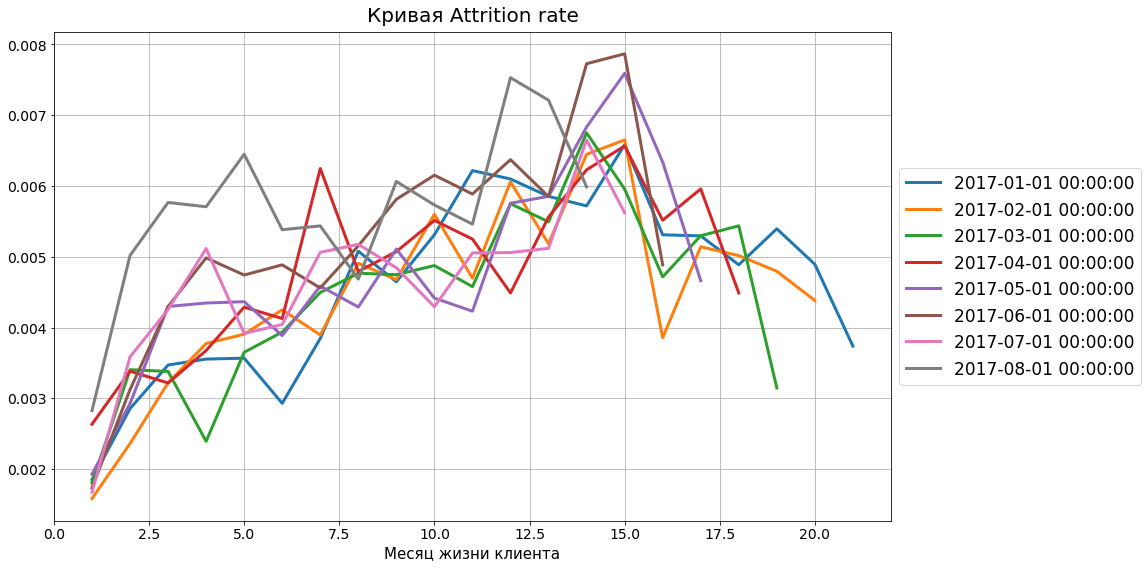

In [5]:
%matplotlib inline
# Выгружаем таблицу c винтажами
attrition_rate_data = df.groupby(["generation_month", "statement_num"])\
    .agg({"becoming_atr_flg":np.sum, "prev_atr_flg":np.sum, "account_rk":np.count_nonzero, "prev_def_flg": np.sum})\
    .rename(columns = ({"becoming_atr_flg":'new_atr_cnt', "prev_atr_flg":'prev_atr_cnt', \
                        "prev_def_flg":'prev_def_cnt', "account_rk":"cnt"}))\
    .eval('attrition_rate = new_atr_cnt / (cnt - prev_atr_cnt - prev_def_cnt)', inplace=False)

def plot_attrition_rate_by_generation(df):
# Your code goes here 
    (df.unstack('generation_month')
            ['attrition_rate']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.show()
plot_attrition_rate_by_generation(attrition_rate_data)

### Объясним форму
- Заметим, что винтажи кривой по различным поколениям имеют похожую тенденцию с некоторым сдвигом из-за разных месяцев
- Сначала все винтажи, в среднем, растут до некоторого максимального значения в диапазоне от 12 до 15 месяца жизни клиента
- После чего идут на спад
- Так как закрытие счета требует от 30 до 60 дней, то с этим могут быть связаны некоторые негладкие участки кривой
- Которые и имеют спад и рост примерно в один-два месяца (но не все)
- Максимум винтажей может быть связан с наступлением годового обслуживания, а смещен он и не находится ровно через 12 месяцев потому что
- Закрытие счета как раз наступает не мгновенно
- После годового обслуживания attrition rate идет на спад, что говорит об уменьшении оттока после оплаты

In [3]:
# df.groupby(["generation_month", "statement_num"]) \
#             .agg({"atr_flg":np.mean}) \
#             .rename(columns = {"atr_flg": 'attrition_ratio'}) \
#             .unstack('generation_month')['attrition_ratio'] 

In [4]:
# attrition_rate_data

## Выберем параметр, который разделяет кривую наилучшим образом

#### Задание 3
* Построить разделение кривой от PD, дохода, канала и параметра X на примере одного поколения (***2 балла***)
* Выбрать наилучший параметр для разделения кривой, проверить стабильность полученной зависимости на разных поколениях (***2 балла***)

In [8]:
def attrition_rate_by_bucket(df, bucket):
    attrition_rate_data = df.query(''' generation_month == '2017-01-01' ''') \
                            .groupby([bucket, "statement_num"])\
                            .agg({"becoming_atr_flg":np.sum, "prev_atr_flg":np.sum, "account_rk":np.count_nonzero, "prev_def_flg": np.sum})\
                            .rename(columns = ({"becoming_atr_flg":'new_atr_cnt', "prev_atr_flg":'prev_atr_cnt', \
                                                "prev_def_flg":'prev_def_cnt', "account_rk":"cnt"}))\
                            .eval('attrition_rate = new_atr_cnt / (cnt - prev_atr_cnt - prev_atr_cnt)', inplace=False) \
                            .unstack(bucket) \
                            ['attrition_rate'] \
                            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

#### Разделение по PD

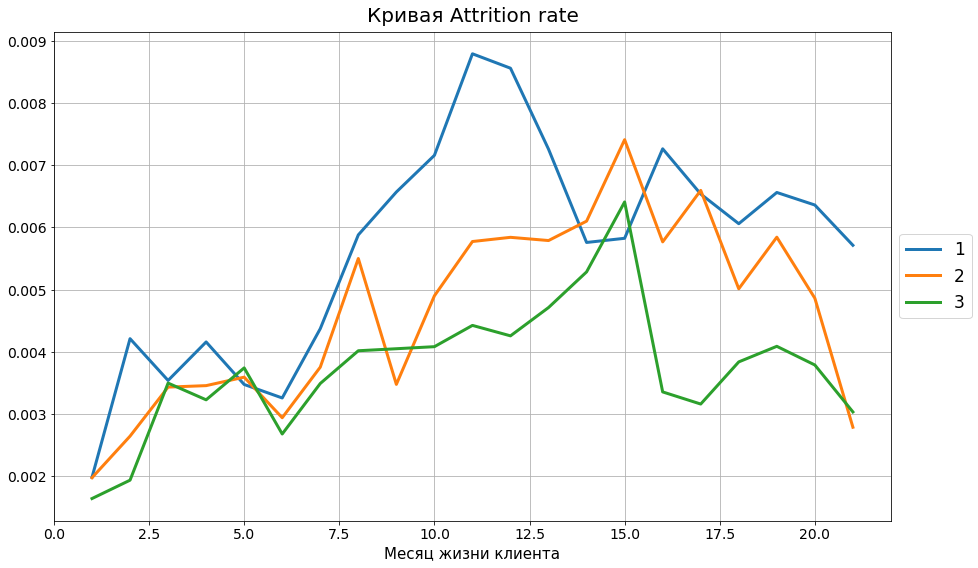

In [9]:
pd_bucket='pd_bucket'
attrition_rate_by_bucket(df, pd_bucket)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Разделение по доходу

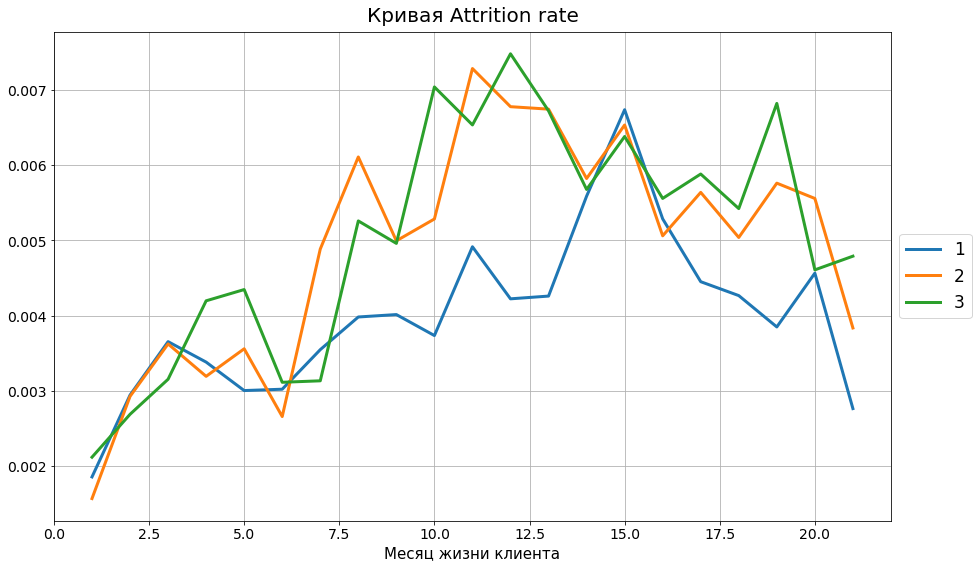

In [10]:
income_bucket = 'income_bucket'
attrition_rate_by_bucket(df, income_bucket)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Разделение по параметру X

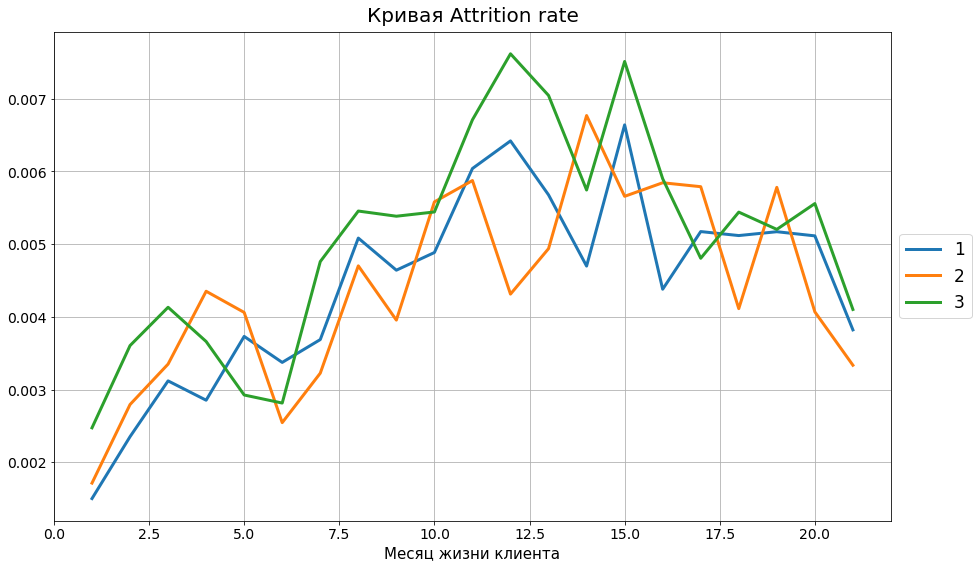

In [11]:
x_parameter_bucket = 'x_parameter_bucket'
attrition_rate_by_bucket(df, x_parameter_bucket)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Разделение по каналу привлечения

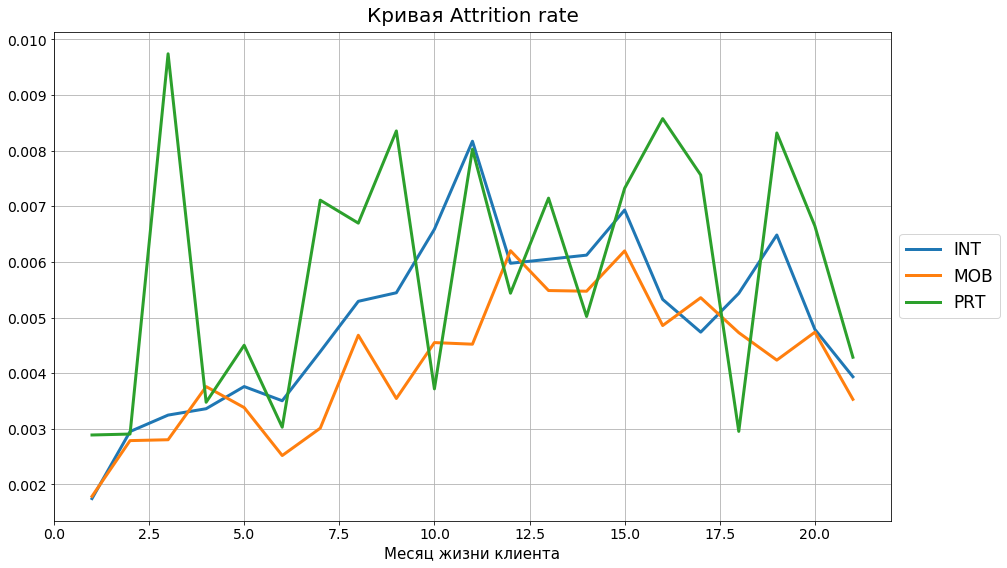

In [12]:
channel = 'channel'
attrition_rate_by_bucket(df, channel)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

- Как видим, разделение не является достаточно хорошим и выбрать лучший параметр затруднительно
- Схлопнем близкие бакеты для предсказания и посмотрим, что получится

In [13]:
def pd_bucket_change(pd_bucket):
    if pd_bucket == 2 or pd_bucket == 3:
        return 2
    else:
        return 1

def income_bucket_change(income_bucket):
    if income_bucket == 2 or income_bucket == 3:
        return 2
    else:
        return 1
    
def channel_change(channel):
    if channel == 'INT' or channel == 'MOB':
        return 'INT OR MOB'
    else:
        return 'PRT'
    
df = df.assign(new_pd_bucket = [0 for i in range(len(df))])
df = df.assign(new_income_bucket = [0 for i in range(len(df))])
df = df.assign(new_channel = [0 for i in range(len(df))])
df.new_pd_bucket = df.pd_bucket.apply(pd_bucket_change)
df.new_income_bucket = df.income_bucket.apply(income_bucket_change)
df.new_channel = df.channel.apply(channel_change)

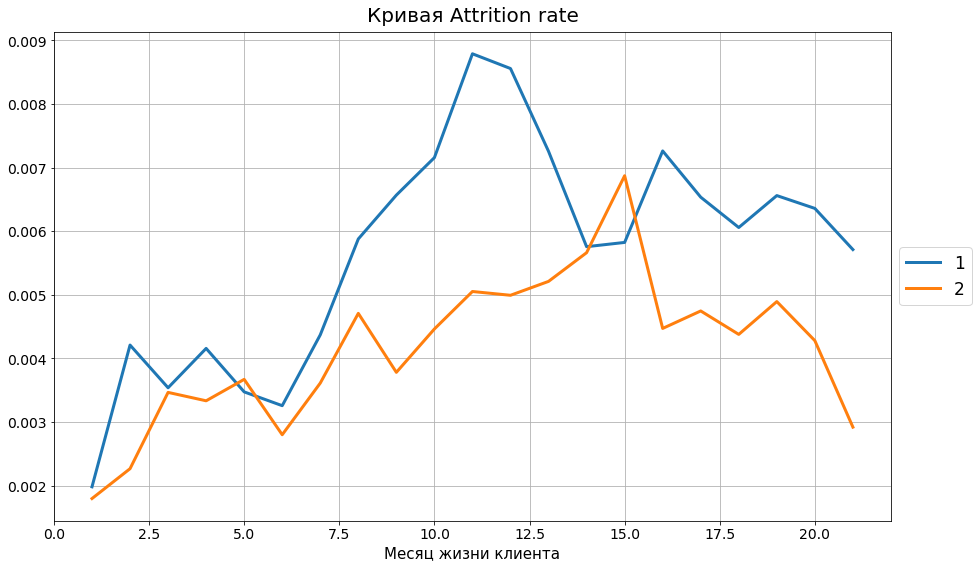

In [14]:
new_pd_bucket = 'new_pd_bucket'
attrition_rate_by_bucket(df, new_pd_bucket)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

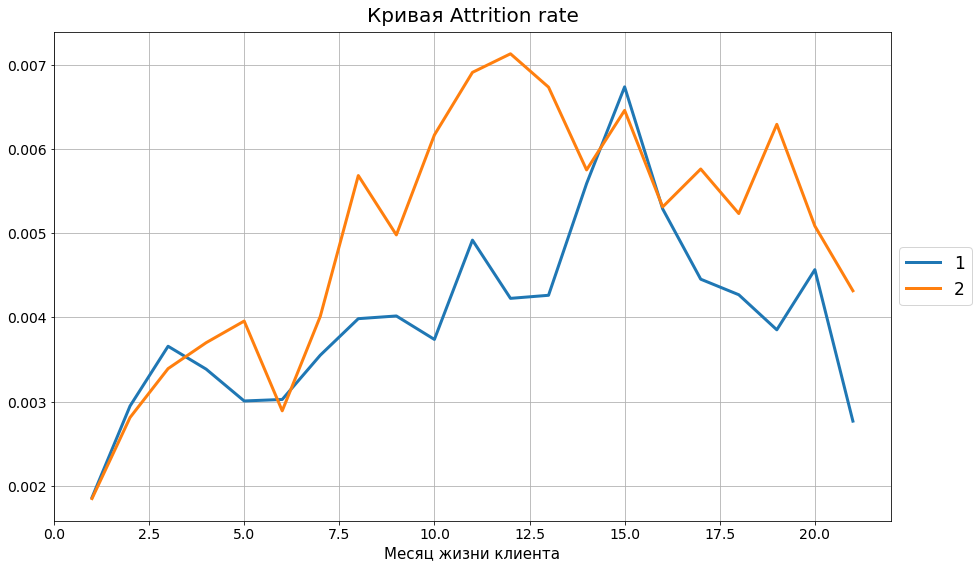

In [15]:
new_income_bucket = 'new_income_bucket'
attrition_rate_by_bucket(df, new_income_bucket)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

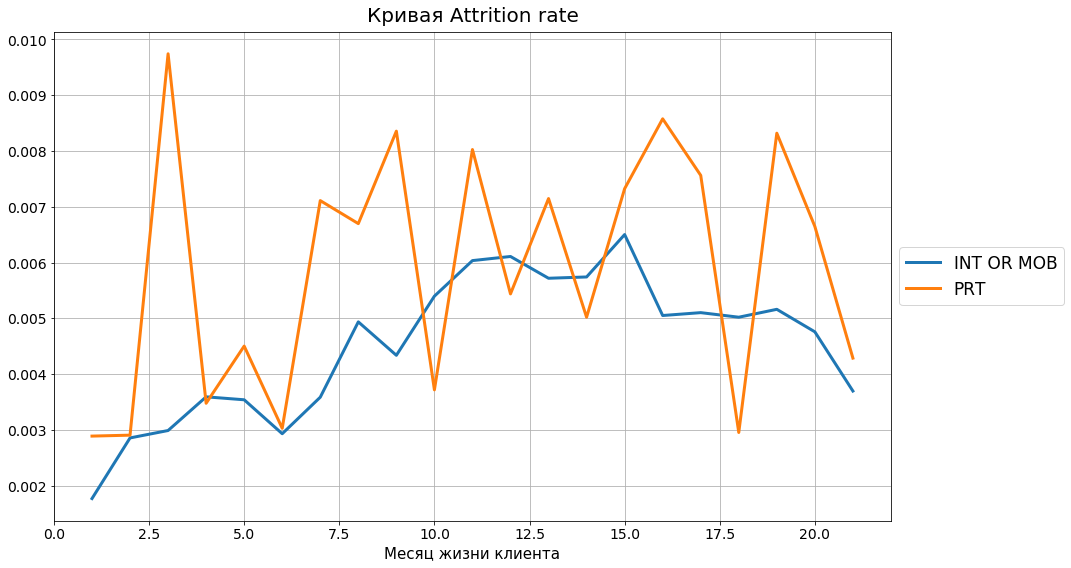

In [16]:
new_channel = 'new_channel'
attrition_rate_by_bucket(df, new_channel)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Вывод: your вывод goes here
- Возникает выбор лучшего параметра между PD и Income, проверим их стабильность
#### Проверим стабильность

### PD

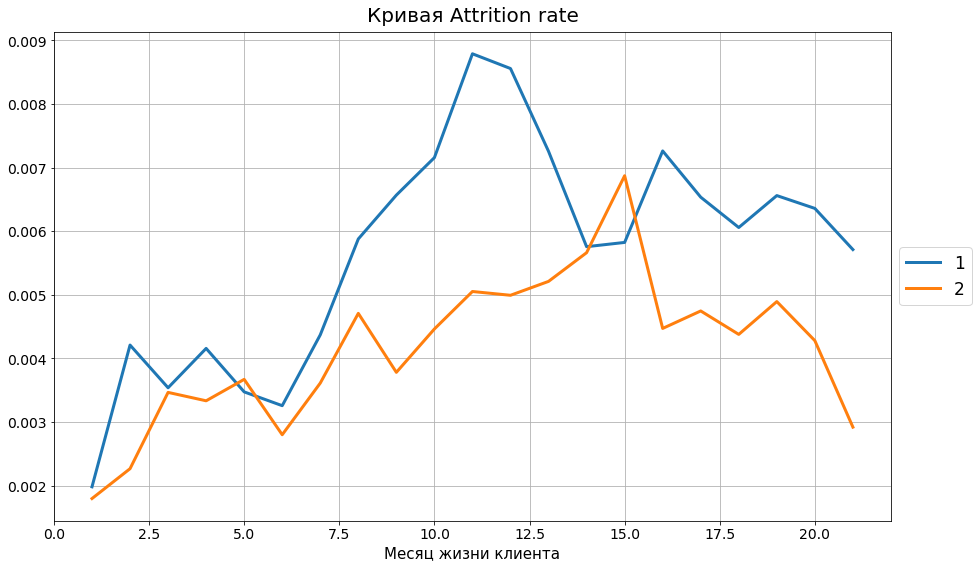

In [17]:
def attrition_rate_by_bucket_generation(df, bucket):
    attrition_rate_data = df.query(''' generation_month == '2017-01-01' ''') \
                            .groupby([bucket, "statement_num"])\
                            .agg({"becoming_atr_flg":np.sum, "prev_atr_flg":np.sum, "account_rk":np.count_nonzero, "prev_def_flg": np.sum})\
                            .rename(columns = ({"becoming_atr_flg":'new_atr_cnt', "prev_atr_flg":'prev_atr_cnt', \
                                                "prev_def_flg":'prev_def_cnt', "account_rk":"cnt"}))\
                            .eval('attrition_rate = new_atr_cnt / (cnt - prev_atr_cnt - prev_atr_cnt)', inplace=False) \
                            .unstack(bucket) \
                            ['attrition_rate'] \
                            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
pd_bucket='pd_bucket'
attrition_rate_by_bucket_generation(df, new_pd_bucket)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

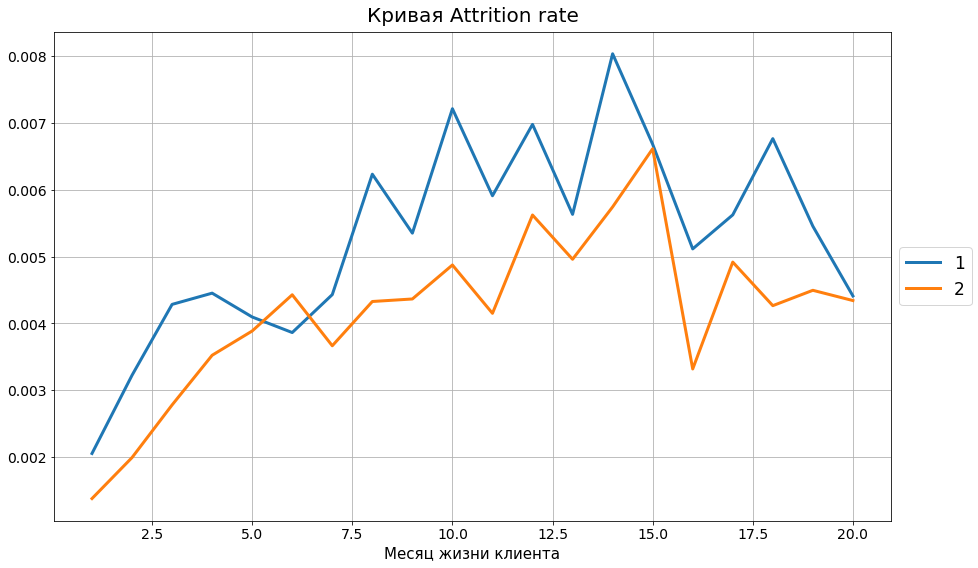

In [18]:
def attrition_rate_by_bucket_generation(df, bucket):
    attrition_rate_data = df.query(''' generation_month == '2017-02-01' ''') \
                            .groupby([bucket, "statement_num"])\
                            .agg({"becoming_atr_flg":np.sum, "prev_atr_flg":np.sum, "account_rk":np.count_nonzero, "prev_def_flg": np.sum})\
                            .rename(columns = ({"becoming_atr_flg":'new_atr_cnt', "prev_atr_flg":'prev_atr_cnt', \
                                                "prev_def_flg":'prev_def_cnt', "account_rk":"cnt"}))\
                            .eval('attrition_rate = new_atr_cnt / (cnt - prev_atr_cnt - prev_atr_cnt)', inplace=False) \
                            .unstack(bucket) \
                            ['attrition_rate'] \
                            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
pd_bucket='pd_bucket'
attrition_rate_by_bucket_generation(df, new_pd_bucket)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

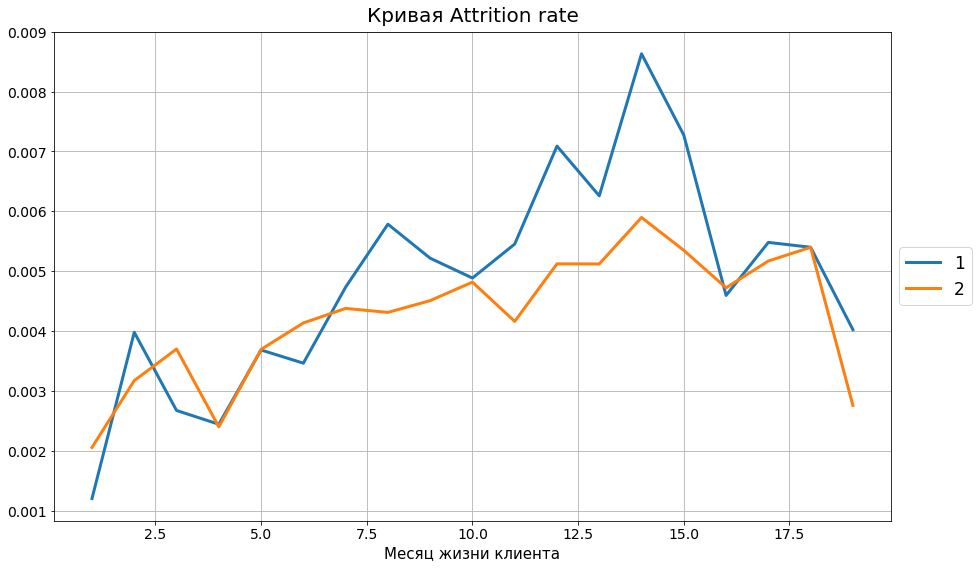

In [19]:
def attrition_rate_by_bucket_generation(df, bucket):
    attrition_rate_data = df.query(''' generation_month == '2017-03-01' ''') \
                            .groupby([bucket, "statement_num"])\
                            .agg({"becoming_atr_flg":np.sum, "prev_atr_flg":np.sum, "account_rk":np.count_nonzero, "prev_def_flg": np.sum})\
                            .rename(columns = ({"becoming_atr_flg":'new_atr_cnt', "prev_atr_flg":'prev_atr_cnt', \
                                                "prev_def_flg":'prev_def_cnt', "account_rk":"cnt"}))\
                            .eval('attrition_rate = new_atr_cnt / (cnt - prev_atr_cnt - prev_atr_cnt)', inplace=False) \
                            .unstack(bucket) \
                            ['attrition_rate'] \
                            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
pd_bucket='pd_bucket'
attrition_rate_by_bucket_generation(df, new_pd_bucket)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

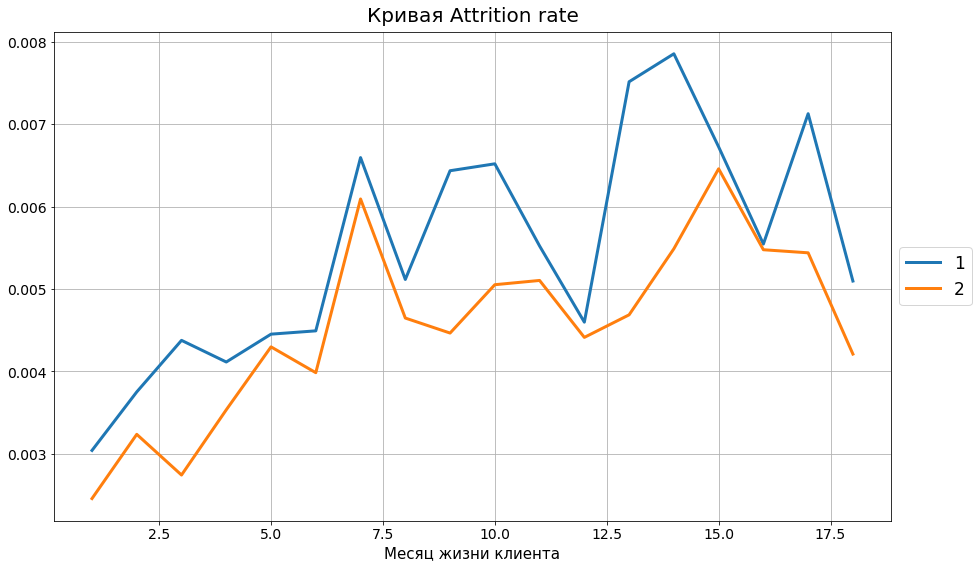

In [20]:
def attrition_rate_by_bucket_generation(df, bucket):
    attrition_rate_data = df.query(''' generation_month == '2017-04-01' ''') \
                            .groupby([bucket, "statement_num"])\
                            .agg({"becoming_atr_flg":np.sum, "prev_atr_flg":np.sum, "account_rk":np.count_nonzero, "prev_def_flg": np.sum})\
                            .rename(columns = ({"becoming_atr_flg":'new_atr_cnt', "prev_atr_flg":'prev_atr_cnt', \
                                                "prev_def_flg":'prev_def_cnt', "account_rk":"cnt"}))\
                            .eval('attrition_rate = new_atr_cnt / (cnt - prev_atr_cnt - prev_atr_cnt)', inplace=False) \
                            .unstack(bucket) \
                            ['attrition_rate'] \
                            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
pd_bucket='pd_bucket'
attrition_rate_by_bucket_generation(df, new_pd_bucket)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

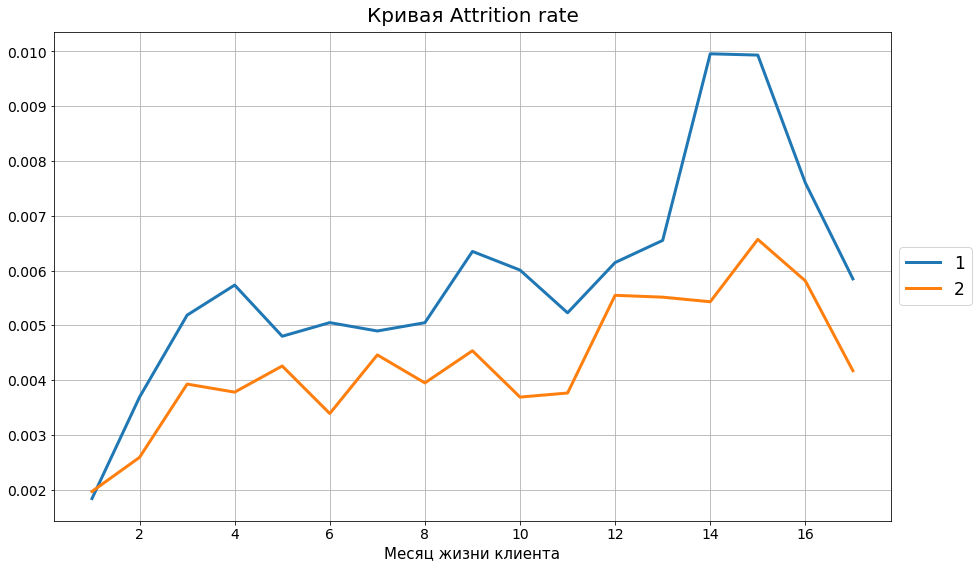

In [21]:
def attrition_rate_by_bucket_generation(df, bucket):
    attrition_rate_data = df.query(''' generation_month == '2017-05-01' ''') \
                            .groupby([bucket, "statement_num"])\
                            .agg({"becoming_atr_flg":np.sum, "prev_atr_flg":np.sum, "account_rk":np.count_nonzero, "prev_def_flg": np.sum})\
                            .rename(columns = ({"becoming_atr_flg":'new_atr_cnt', "prev_atr_flg":'prev_atr_cnt', \
                                                "prev_def_flg":'prev_def_cnt', "account_rk":"cnt"}))\
                            .eval('attrition_rate = new_atr_cnt / (cnt - prev_atr_cnt - prev_atr_cnt)', inplace=False) \
                            .unstack(bucket) \
                            ['attrition_rate'] \
                            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
pd_bucket='pd_bucket'
attrition_rate_by_bucket_generation(df, new_pd_bucket)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

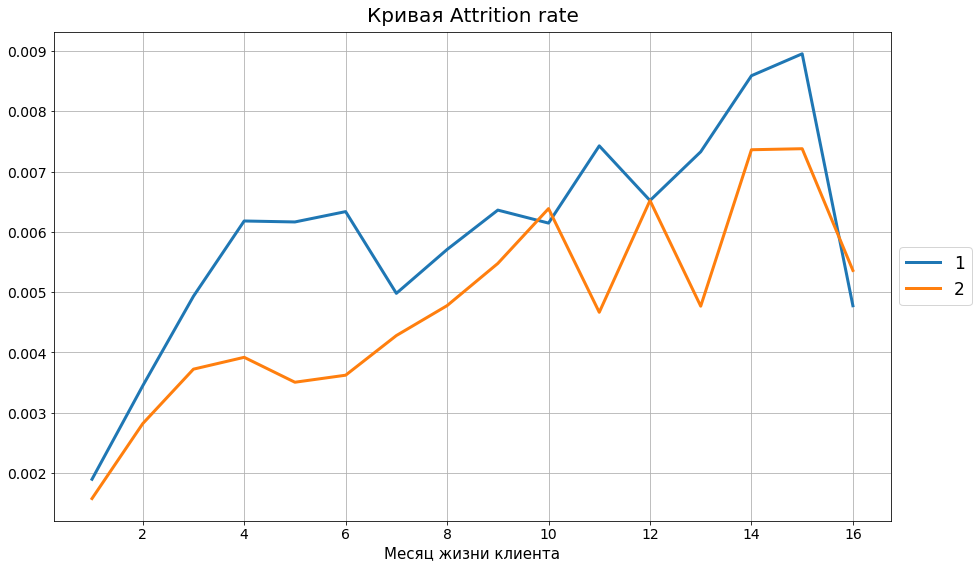

In [22]:
def attrition_rate_by_bucket_generation(df, bucket):
    attrition_rate_data = df.query(''' generation_month == '2017-06-01' ''') \
                            .groupby([bucket, "statement_num"])\
                            .agg({"becoming_atr_flg":np.sum, "prev_atr_flg":np.sum, "account_rk":np.count_nonzero, "prev_def_flg": np.sum})\
                            .rename(columns = ({"becoming_atr_flg":'new_atr_cnt', "prev_atr_flg":'prev_atr_cnt', \
                                                "prev_def_flg":'prev_def_cnt', "account_rk":"cnt"}))\
                            .eval('attrition_rate = new_atr_cnt / (cnt - prev_atr_cnt - prev_atr_cnt)', inplace=False) \
                            .unstack(bucket) \
                            ['attrition_rate'] \
                            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
pd_bucket='pd_bucket'
attrition_rate_by_bucket_generation(df, new_pd_bucket)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

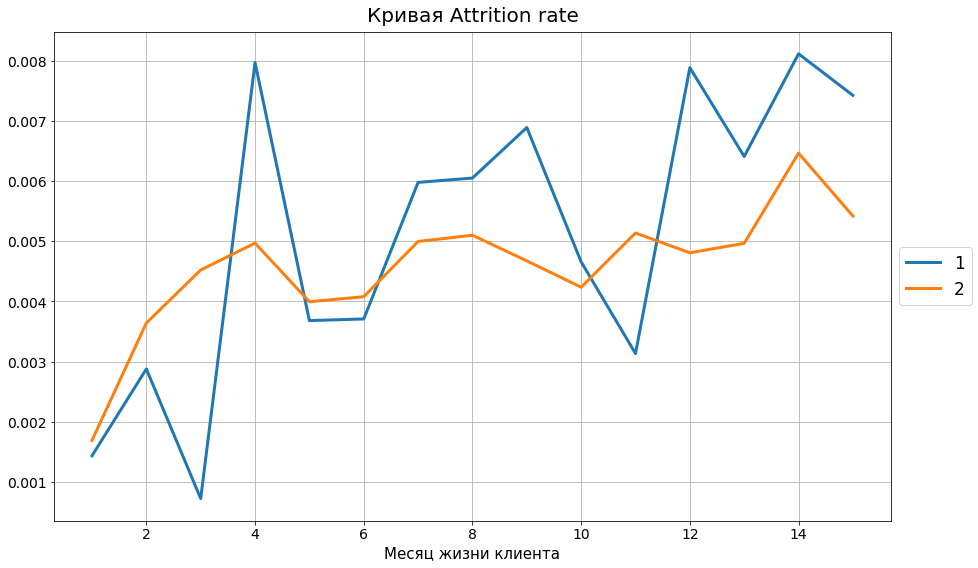

In [23]:
def attrition_rate_by_bucket_generation(df, bucket):
    attrition_rate_data = df.query(''' generation_month == '2017-07-01' ''') \
                            .groupby([bucket, "statement_num"])\
                            .agg({"becoming_atr_flg":np.sum, "prev_atr_flg":np.sum, "account_rk":np.count_nonzero, "prev_def_flg": np.sum})\
                            .rename(columns = ({"becoming_atr_flg":'new_atr_cnt', "prev_atr_flg":'prev_atr_cnt', \
                                                "prev_def_flg":'prev_def_cnt', "account_rk":"cnt"}))\
                            .eval('attrition_rate = new_atr_cnt / (cnt - prev_atr_cnt - prev_atr_cnt)', inplace=False) \
                            .unstack(bucket) \
                            ['attrition_rate'] \
                            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
pd_bucket='pd_bucket'
attrition_rate_by_bucket_generation(df, new_pd_bucket)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

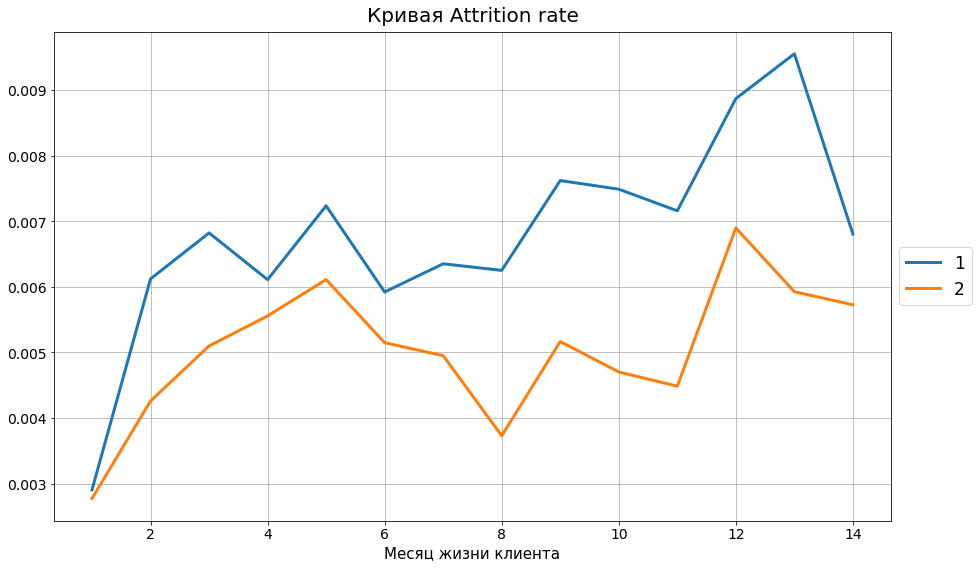

In [24]:
def attrition_rate_by_bucket_generation(df, bucket):
    attrition_rate_data = df.query(''' generation_month == '2017-08-01' ''') \
                            .groupby([bucket, "statement_num"])\
                            .agg({"becoming_atr_flg":np.sum, "prev_atr_flg":np.sum, "account_rk":np.count_nonzero, "prev_def_flg": np.sum})\
                            .rename(columns = ({"becoming_atr_flg":'new_atr_cnt', "prev_atr_flg":'prev_atr_cnt', \
                                                "prev_def_flg":'prev_def_cnt', "account_rk":"cnt"}))\
                            .eval('attrition_rate = new_atr_cnt / (cnt - prev_atr_cnt - prev_atr_cnt)', inplace=False) \
                            .unstack(bucket) \
                            ['attrition_rate'] \
                            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
pd_bucket='pd_bucket'
attrition_rate_by_bucket_generation(df, new_pd_bucket)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

# INCOME

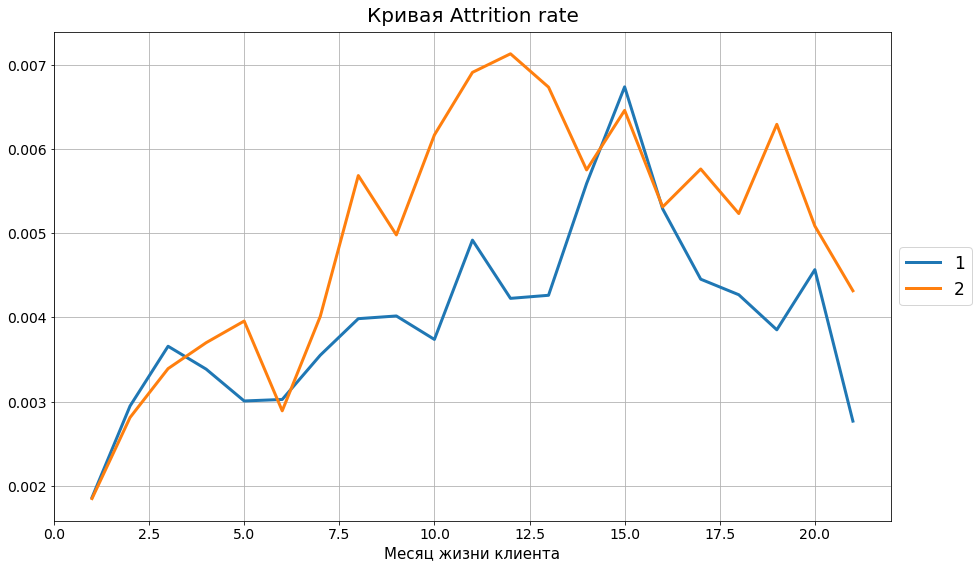

In [25]:
def attrition_rate_by_bucket_generation(df, bucket):
    attrition_rate_data = df.query(''' generation_month == '2017-01-01' ''') \
                            .groupby([bucket, "statement_num"])\
                            .agg({"becoming_atr_flg":np.sum, "prev_atr_flg":np.sum, "account_rk":np.count_nonzero, "prev_def_flg": np.sum})\
                            .rename(columns = ({"becoming_atr_flg":'new_atr_cnt', "prev_atr_flg":'prev_atr_cnt', \
                                                "prev_def_flg":'prev_def_cnt', "account_rk":"cnt"}))\
                            .eval('attrition_rate = new_atr_cnt / (cnt - prev_atr_cnt - prev_atr_cnt)', inplace=False) \
                            .unstack(bucket) \
                            ['attrition_rate'] \
                            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
pd_bucket='pd_bucket'
attrition_rate_by_bucket_generation(df, new_income_bucket)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

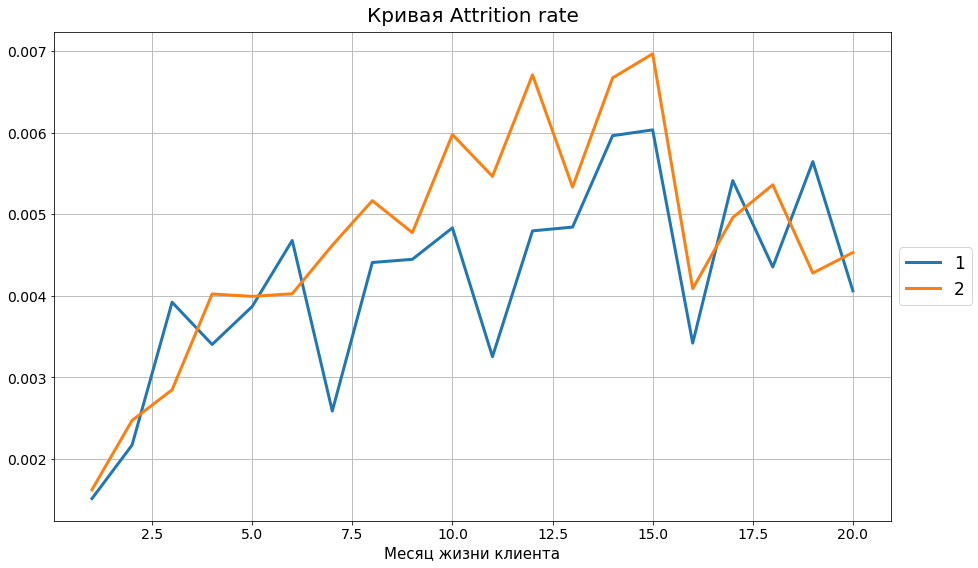

In [26]:
def attrition_rate_by_bucket_generation(df, bucket):
    attrition_rate_data = df.query(''' generation_month == '2017-02-01' ''') \
                            .groupby([bucket, "statement_num"])\
                            .agg({"becoming_atr_flg":np.sum, "prev_atr_flg":np.sum, "account_rk":np.count_nonzero, "prev_def_flg": np.sum})\
                            .rename(columns = ({"becoming_atr_flg":'new_atr_cnt', "prev_atr_flg":'prev_atr_cnt', \
                                                "prev_def_flg":'prev_def_cnt', "account_rk":"cnt"}))\
                            .eval('attrition_rate = new_atr_cnt / (cnt - prev_atr_cnt - prev_atr_cnt)', inplace=False) \
                            .unstack(bucket) \
                            ['attrition_rate'] \
                            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
pd_bucket='pd_bucket'
attrition_rate_by_bucket_generation(df, new_income_bucket)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

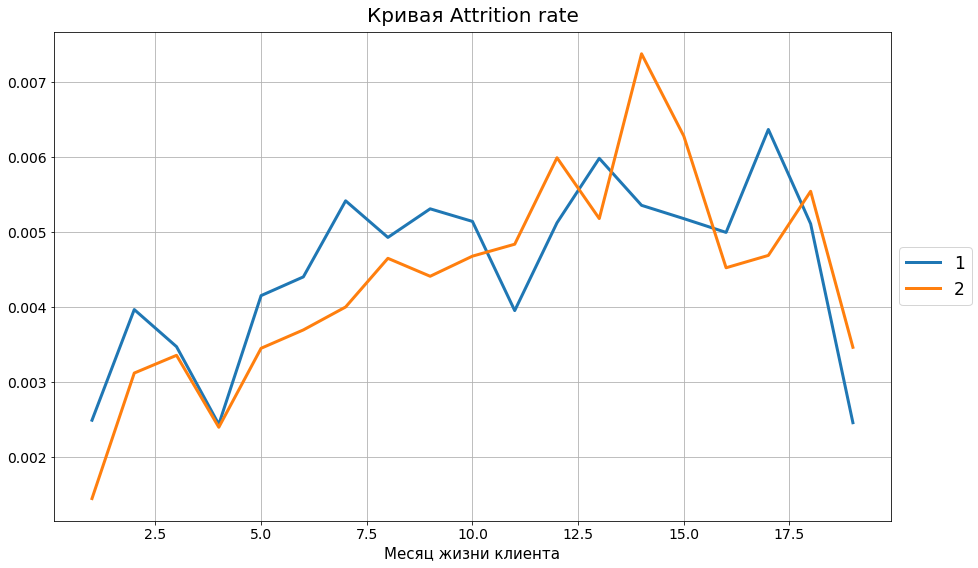

In [27]:
def attrition_rate_by_bucket_generation(df, bucket):
    attrition_rate_data = df.query(''' generation_month == '2017-03-01' ''') \
                            .groupby([bucket, "statement_num"])\
                            .agg({"becoming_atr_flg":np.sum, "prev_atr_flg":np.sum, "account_rk":np.count_nonzero, "prev_def_flg": np.sum})\
                            .rename(columns = ({"becoming_atr_flg":'new_atr_cnt', "prev_atr_flg":'prev_atr_cnt', \
                                                "prev_def_flg":'prev_def_cnt', "account_rk":"cnt"}))\
                            .eval('attrition_rate = new_atr_cnt / (cnt - prev_atr_cnt - prev_atr_cnt)', inplace=False) \
                            .unstack(bucket) \
                            ['attrition_rate'] \
                            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
pd_bucket='pd_bucket'
attrition_rate_by_bucket_generation(df, new_income_bucket)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

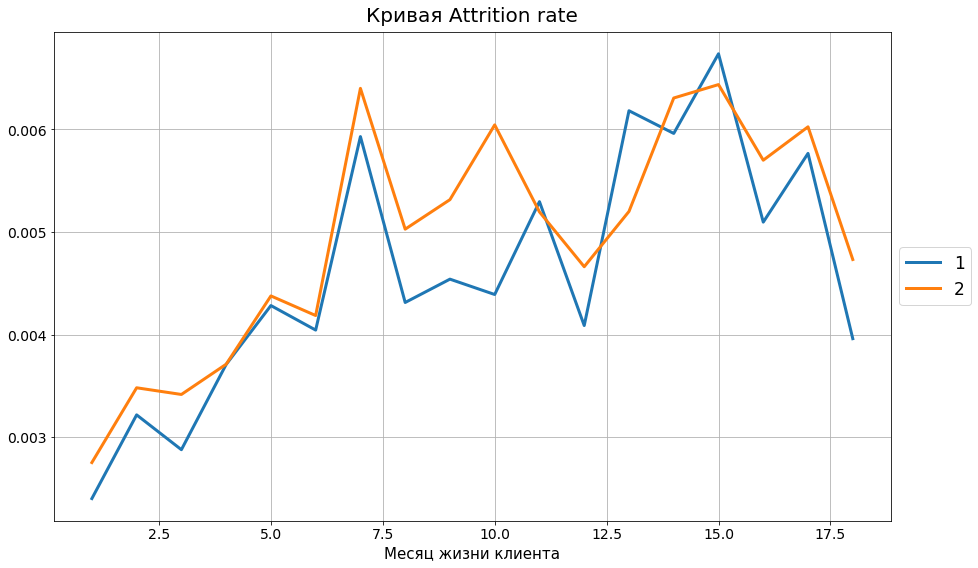

In [28]:
def attrition_rate_by_bucket_generation(df, bucket):
    attrition_rate_data = df.query(''' generation_month == '2017-04-01' ''') \
                            .groupby([bucket, "statement_num"])\
                            .agg({"becoming_atr_flg":np.sum, "prev_atr_flg":np.sum, "account_rk":np.count_nonzero, "prev_def_flg": np.sum})\
                            .rename(columns = ({"becoming_atr_flg":'new_atr_cnt', "prev_atr_flg":'prev_atr_cnt', \
                                                "prev_def_flg":'prev_def_cnt', "account_rk":"cnt"}))\
                            .eval('attrition_rate = new_atr_cnt / (cnt - prev_atr_cnt - prev_atr_cnt)', inplace=False) \
                            .unstack(bucket) \
                            ['attrition_rate'] \
                            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
pd_bucket='pd_bucket'
attrition_rate_by_bucket_generation(df, new_income_bucket)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

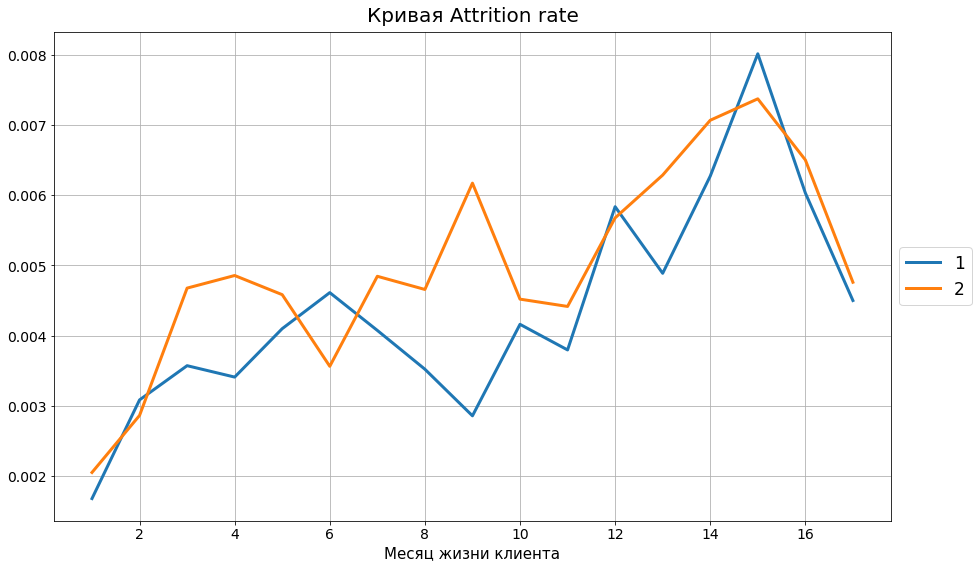

In [29]:
def attrition_rate_by_bucket_generation(df, bucket):
    attrition_rate_data = df.query(''' generation_month == '2017-05-01' ''') \
                            .groupby([bucket, "statement_num"])\
                            .agg({"becoming_atr_flg":np.sum, "prev_atr_flg":np.sum, "account_rk":np.count_nonzero, "prev_def_flg": np.sum})\
                            .rename(columns = ({"becoming_atr_flg":'new_atr_cnt', "prev_atr_flg":'prev_atr_cnt', \
                                                "prev_def_flg":'prev_def_cnt', "account_rk":"cnt"}))\
                            .eval('attrition_rate = new_atr_cnt / (cnt - prev_atr_cnt - prev_atr_cnt)', inplace=False) \
                            .unstack(bucket) \
                            ['attrition_rate'] \
                            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
pd_bucket='pd_bucket'
attrition_rate_by_bucket_generation(df, new_income_bucket)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

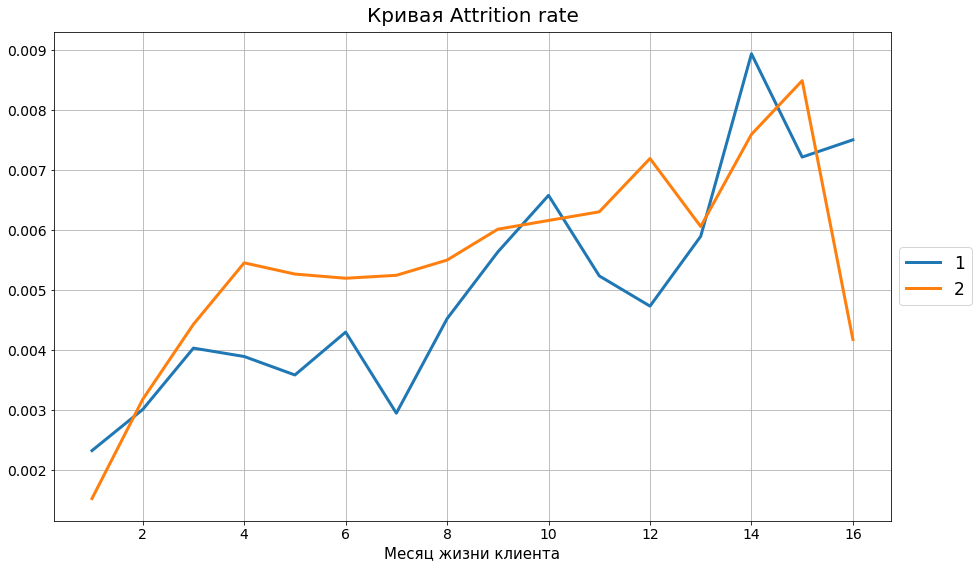

In [30]:
def attrition_rate_by_bucket_generation(df, bucket):
    attrition_rate_data = df.query(''' generation_month == '2017-06-01' ''') \
                            .groupby([bucket, "statement_num"])\
                            .agg({"becoming_atr_flg":np.sum, "prev_atr_flg":np.sum, "account_rk":np.count_nonzero, "prev_def_flg": np.sum})\
                            .rename(columns = ({"becoming_atr_flg":'new_atr_cnt', "prev_atr_flg":'prev_atr_cnt', \
                                                "prev_def_flg":'prev_def_cnt', "account_rk":"cnt"}))\
                            .eval('attrition_rate = new_atr_cnt / (cnt - prev_atr_cnt - prev_atr_cnt)', inplace=False) \
                            .unstack(bucket) \
                            ['attrition_rate'] \
                            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
pd_bucket='pd_bucket'
attrition_rate_by_bucket_generation(df, new_income_bucket)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

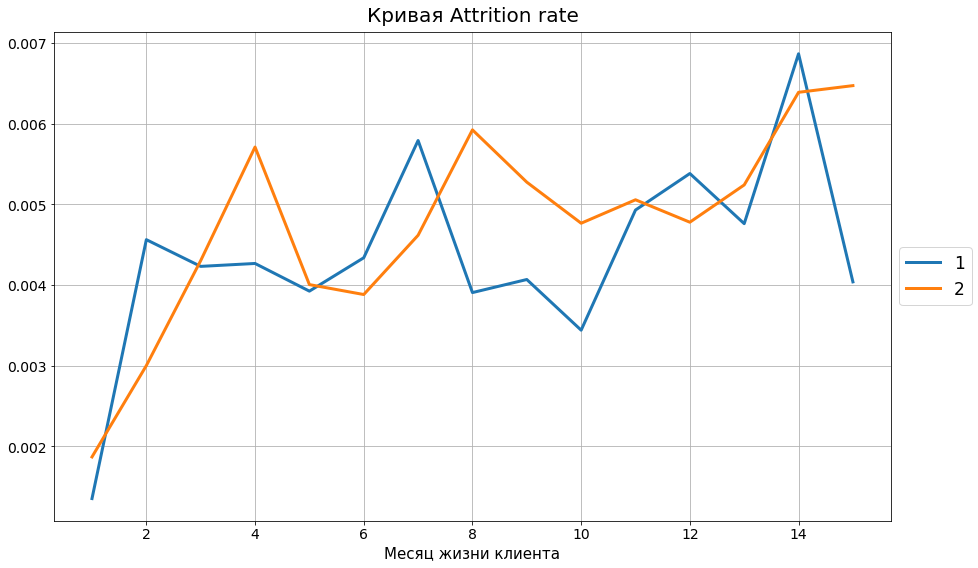

In [31]:
def attrition_rate_by_bucket_generation(df, bucket):
    attrition_rate_data = df.query(''' generation_month == '2017-07-01' ''') \
                            .groupby([bucket, "statement_num"])\
                            .agg({"becoming_atr_flg":np.sum, "prev_atr_flg":np.sum, "account_rk":np.count_nonzero, "prev_def_flg": np.sum})\
                            .rename(columns = ({"becoming_atr_flg":'new_atr_cnt', "prev_atr_flg":'prev_atr_cnt', \
                                                "prev_def_flg":'prev_def_cnt', "account_rk":"cnt"}))\
                            .eval('attrition_rate = new_atr_cnt / (cnt - prev_atr_cnt - prev_atr_cnt)', inplace=False) \
                            .unstack(bucket) \
                            ['attrition_rate'] \
                            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
pd_bucket='pd_bucket'
attrition_rate_by_bucket_generation(df, new_income_bucket)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

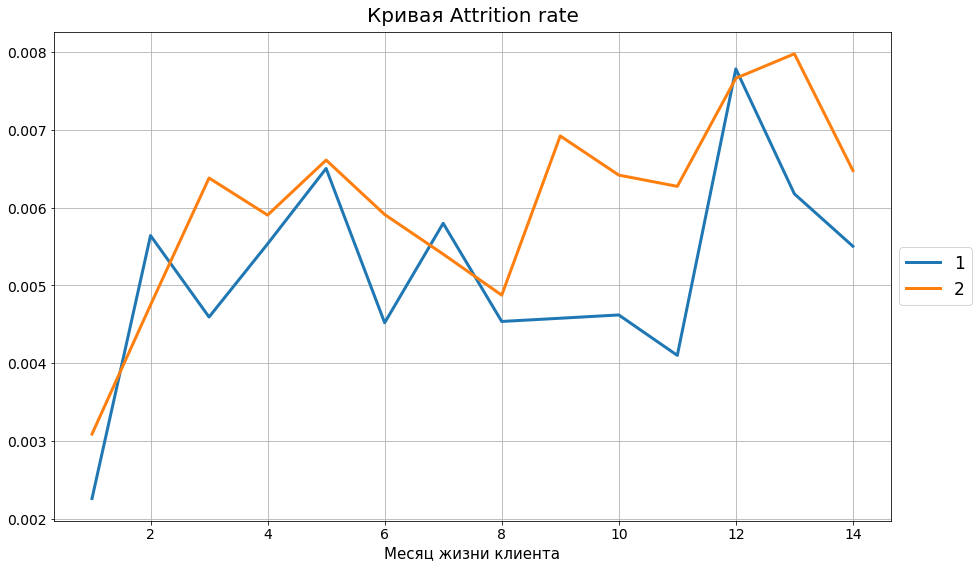

In [32]:
def attrition_rate_by_bucket_generation(df, bucket):
    attrition_rate_data = df.query(''' generation_month == '2017-08-01' ''') \
                            .groupby([bucket, "statement_num"])\
                            .agg({"becoming_atr_flg":np.sum, "prev_atr_flg":np.sum, "account_rk":np.count_nonzero, "prev_def_flg": np.sum})\
                            .rename(columns = ({"becoming_atr_flg":'new_atr_cnt', "prev_atr_flg":'prev_atr_cnt', \
                                                "prev_def_flg":'prev_def_cnt', "account_rk":"cnt"}))\
                            .eval('attrition_rate = new_atr_cnt / (cnt - prev_atr_cnt - prev_atr_cnt)', inplace=False) \
                            .unstack(bucket) \
                            ['attrition_rate'] \
                            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
pd_bucket='pd_bucket'
attrition_rate_by_bucket_generation(df, new_income_bucket)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

# ВЫВОД
- Лучшим параметром для разделения является PD, он лучше разделяет и более стабилен по поколениям
- Для того, чтобы добиться такого вывода, было решено перейти к двум бакетам для анализа разделения

## Проверим наличие "странных" поколений и временных трендов

#### Задание 4
* Построить винтажи по группам выбранного параметра, изучить наличие "особых" поколений, исключить их из рассмотрения, построить средние кривые (***2 балла***)

In [33]:
%matplotlib inline
# Выгружаем таблицу c винтажами

attrition_rate_data = df.groupby(["generation_month", 'pd_bucket', "statement_num"])\
    .agg({"becoming_atr_flg":np.sum, "prev_atr_flg":np.sum, "account_rk":np.count_nonzero, "prev_def_flg": np.sum})\
    .rename(columns = ({"becoming_atr_flg":'new_atr_cnt', "prev_atr_flg":'prev_atr_cnt', \
                        "prev_def_flg":'prev_def_cnt', "account_rk":"cnt"}))\
    .eval('attrition_rate = new_atr_cnt / (cnt - prev_atr_cnt - prev_atr_cnt)', inplace=False)
    
# Делаем список бакетов

buckets = df['pd_bucket'].drop_duplicates().sort_values(ascending = True)

def plot_attrition_rate_by_bucket(pd_bucket):
# Your code goes here 
    cur_df = attrition_rate_data.query('pd_bucket == ' + str(pd_bucket))
    (cur_df.unstack('generation_month')
            ['attrition_rate']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)
    
# Отображаем его при помощи ipywidget, чтобы получить интерактивность

vintages_graph = interactive(plot_attrition_rate_by_bucket, pd_bucket = buckets)
vintages_graph

interactive(children=(Dropdown(description='pd_bucket', options=(1, 2, 3), value=1), Output()), _dom_classes=(…

### Анализ "странных" поколений
- в 1 бакете выделяется поколение июля, запомним его, пока не удаляем, потому что минимальные и максимальные значения не сильно выделяются
- Поэтому было решено не выбрасывать поколение июля
- во 2 бакете не наблюдается "странных" поколений
- в 3 бакете сильно выделяется поколение июня, его следует выбросить
- Также следует обратить внимание на поколение августа, но пока его оставим

#### Исключаем эти поколения из расчета среднего

In [34]:
# Исключаем "странные" поколения

exception_query = ''' ~(((generation_month == '2017-06-01') & (pd_bucket == 3))) '''
attrition_rate_data.query(exception_query, inplace = True)

### Посмотрим, что получается без июня 3 бакета

In [35]:
# Считаем среднее

attrition_rate_mean = attrition_rate_data.groupby(['statement_num', 'pd_bucket'])\
    .agg({'attrition_rate':np.mean})\
    .rename(columns = {'attrition_rate':'Среднее'})

buckets = df['pd_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_attrition_rate_mean(pd_bucket):
    vintages_graph = attrition_rate_data.query('pd_bucket == ' + str(pd_bucket))\
            .unstack('generation_month')\
            ['attrition_rate']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (attrition_rate_mean.query('pd_bucket == ' + str(pd_bucket))
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

vintages_graph = interactive(plot_attrition_rate_mean, pd_bucket = sorted(buckets))
vintages_graph

interactive(children=(Dropdown(description='pd_bucket', options=(1, 2, 3), value=1), Output()), _dom_classes=(…

### Продолжаем анализ "странных" поколений
- Кажется логичным убрать из рассмотрения еще и август 3 бакета

In [36]:
# Исключаем "странные" поколения

exception_query = ''' ~(((generation_month == '2017-08-01') & (pd_bucket == 3))) '''
attrition_rate_data.query(exception_query, inplace = True)

In [37]:
# Считаем среднее

attrition_rate_mean = attrition_rate_data.groupby(['statement_num', 'pd_bucket'])\
    .agg({'attrition_rate':np.mean})\
    .rename(columns = {'attrition_rate':'Среднее'})

buckets = df['pd_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_attrition_rate_mean(pd_bucket):
    vintages_graph = attrition_rate_data.query('pd_bucket == ' + str(pd_bucket))\
            .unstack('generation_month')\
            ['attrition_rate']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (attrition_rate_mean.query('pd_bucket == ' + str(pd_bucket))
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

vintages_graph = interactive(plot_attrition_rate_mean, pd_bucket = sorted(buckets))
vintages_graph

interactive(children=(Dropdown(description='pd_bucket', options=(1, 2, 3), value=1), Output()), _dom_classes=(…

### Продолжаем анализ "странных" поколений
- Все-таки уберем июль 1 бакета

In [38]:
# Исключаем "странные" поколения

exception_query = ''' ~(((generation_month == '2017-07-01') & (pd_bucket == 1))) '''
attrition_rate_data.query(exception_query, inplace = True)

In [39]:
# Считаем среднее

attrition_rate_mean = attrition_rate_data.groupby(['statement_num', 'pd_bucket'])\
    .agg({'attrition_rate':np.mean})\
    .rename(columns = {'attrition_rate':'Среднее'})

buckets = df['pd_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_attrition_rate_mean(pd_bucket):
    vintages_graph = attrition_rate_data.query('pd_bucket == ' + str(pd_bucket))\
            .unstack('generation_month')\
            ['attrition_rate']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (attrition_rate_mean.query('pd_bucket == ' + str(pd_bucket))
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

vintages_graph = interactive(plot_attrition_rate_mean, pd_bucket = sorted(buckets))
vintages_graph

interactive(children=(Dropdown(description='pd_bucket', options=(1, 2, 3), value=1), Output()), _dom_classes=(…

- В итоге исключили 3 поколения
- Июль 1 бакета
- Июль, августа 3 бакета

## Научимся сглаживать полученные средние кривые

#### Задание 5
* Сгладить полученные кривые, вывести итоговый прогноз (***3 балла***)

    Можно использовать любой из методов, представленных на семинаре, либо любой другой, кажущийся вам логичным.
    
    Обратите внимание, что можно использовать разные формулы и даже разные подходы на отдельных участках аппроксимации. 

#### Рассмотрим одну группу PD и сделаем линейное приближение (на 3 бакете)

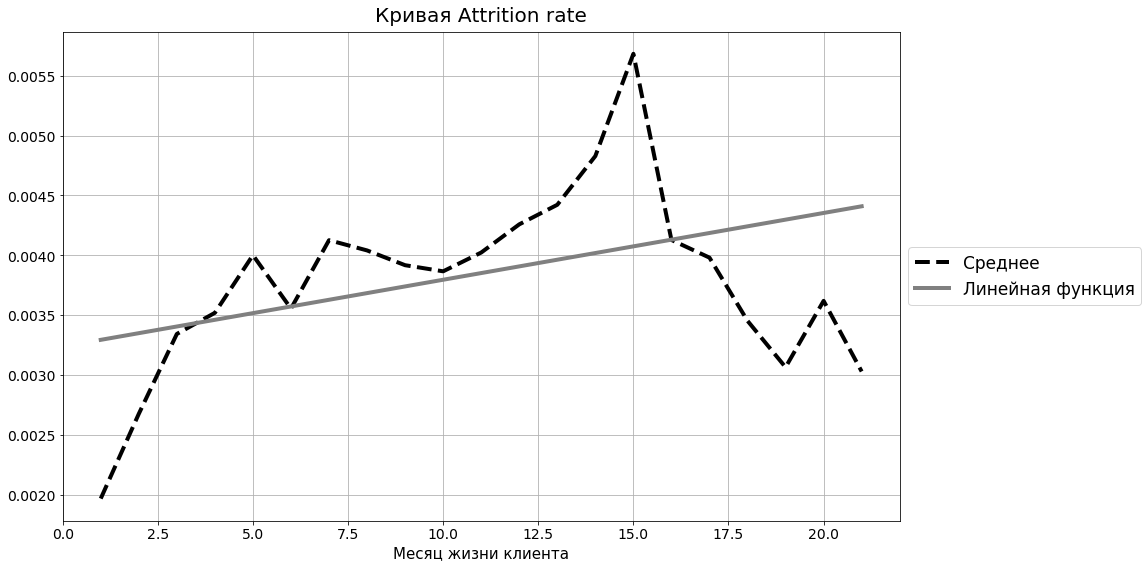

In [40]:
def linear_approximation(df, start=1, finish=20):
    df_res = pd.DataFrame(df)
    df_res['Линейная функция'] = df['Среднее']                                                # Копируем средние значения
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], 1)  # Коэффициенты уравнения прямой
    linear_coeff = np.poly1d(linear_coeff)                                                    # Превращаем коэффициенты в функцию
    df_res.loc[start:finish, 'Линейная функция'] = linear_coeff(np.arange(start, finish+1))   # Записываем приближение
    df_res.loc[finish+1:, 'Линейная функция'] = linear_coeff(finish+1)                        # Продолжаем кривую константой
    return df_res

# Делаем аппроксимацию

df_linear = attrition_rate_mean.query('pd_bucket == 3').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 1, 20)

# Строим получившийся график

plt.figure(figsize=(15, 9))
df_linear['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_linear['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Будем повышать start, но тогда есть риск переобучиться

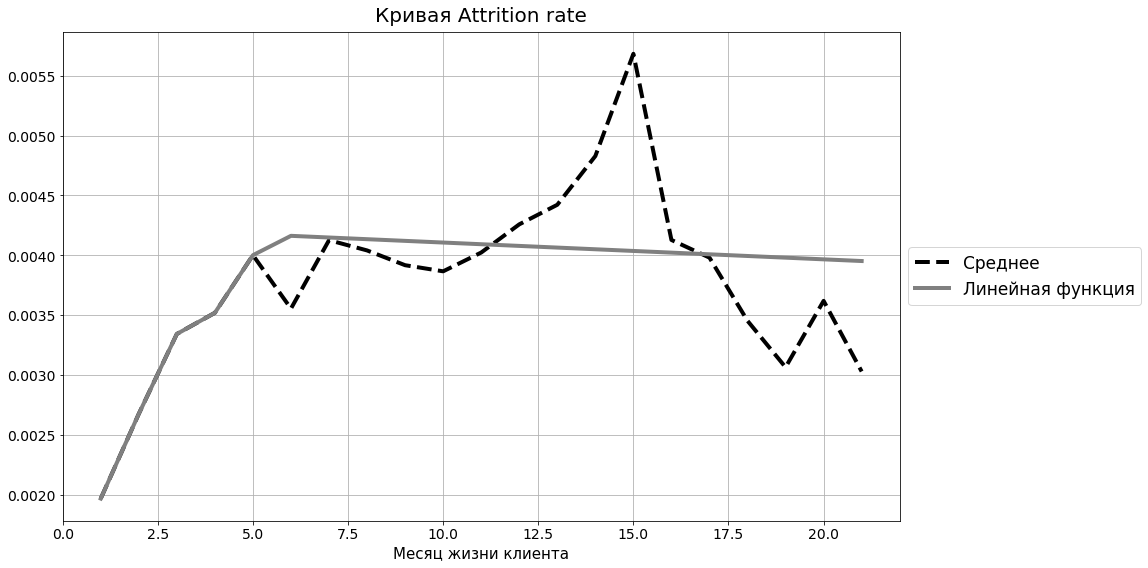

In [41]:
# Делаем аппроксимацию

df_linear = attrition_rate_mean.query('pd_bucket == 3').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 6, 20)

# Строим получившийся график

plt.figure(figsize=(15, 9))
df_linear['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_linear['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

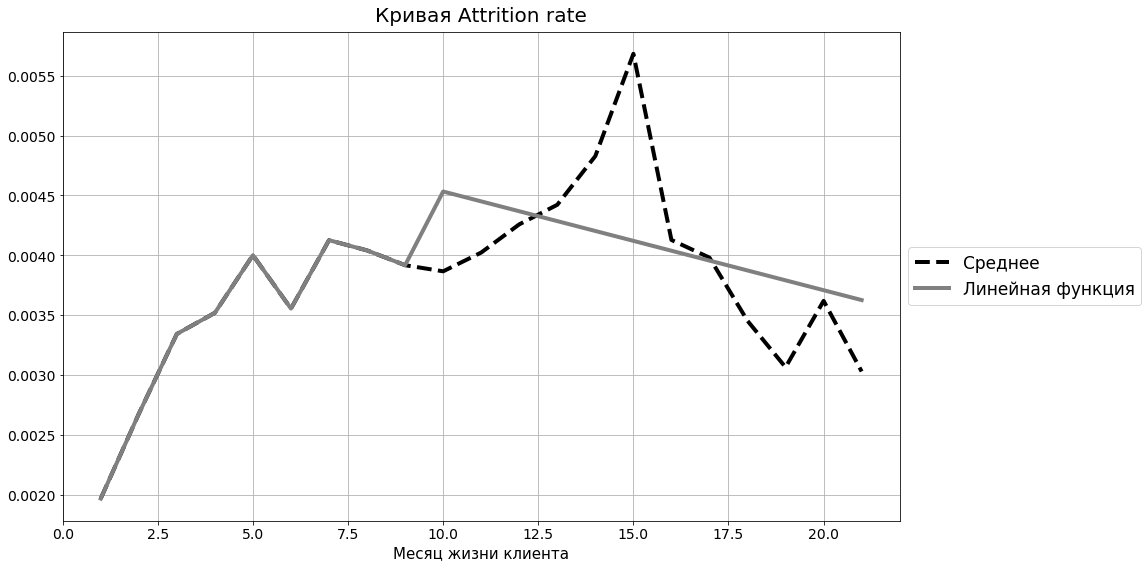

In [42]:
# Делаем аппроксимацию

df_linear = attrition_rate_mean.query('pd_bucket == 3').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 10, 20)

# Строим получившийся график

plt.figure(figsize=(15, 9))
df_linear['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_linear['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Посмотрим результат на всех бакетах

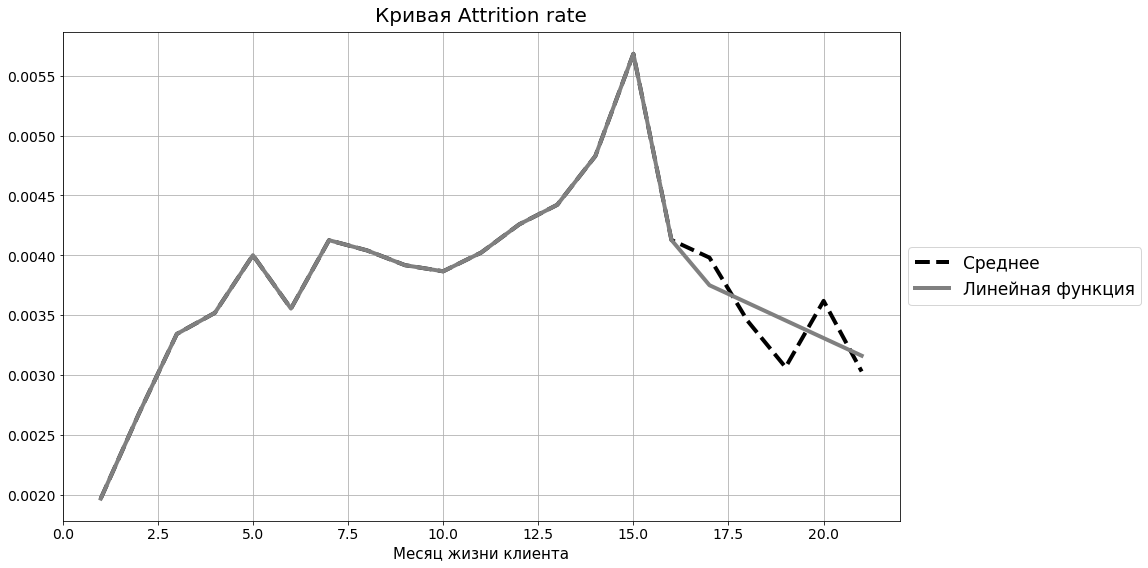

In [43]:
# Делаем аппроксимацию

df_linear = attrition_rate_mean.query('pd_bucket == 3').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 17, 20)

# Строим получившийся график

plt.figure(figsize=(15, 9))
df_linear['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_linear['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

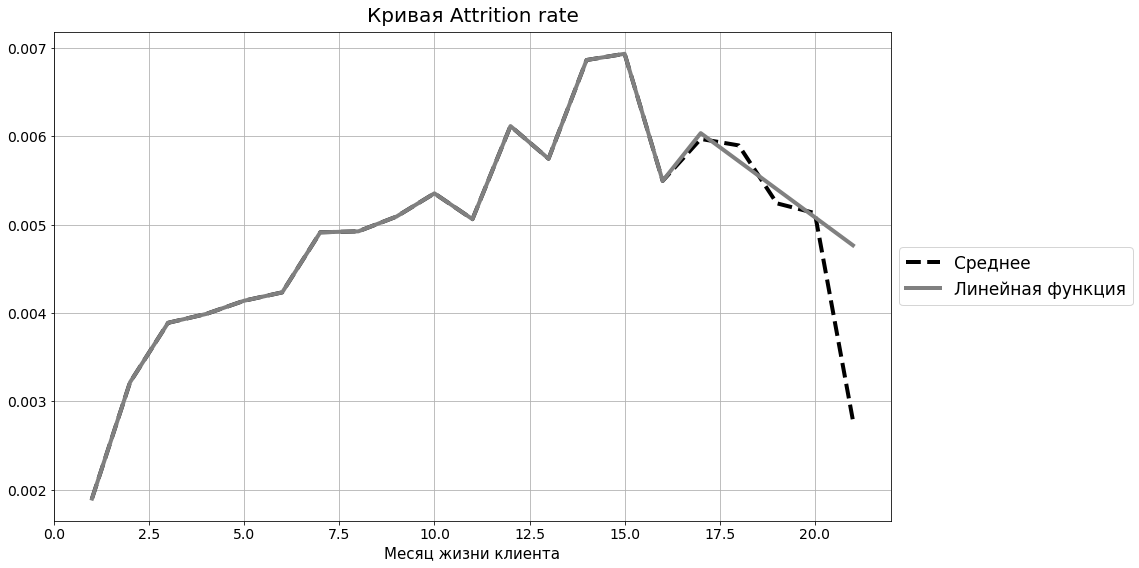

In [44]:
# Делаем аппроксимацию

df_linear = attrition_rate_mean.query('pd_bucket == 2').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 17, 20)

# Строим получившийся график

plt.figure(figsize=(15, 9))
df_linear['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_linear['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Казалось бы, мы сгладили, но на самом деле просто подстроились под зависимость
### Переходим к полиному

#### Сделаем приближение полиномом в общем виде

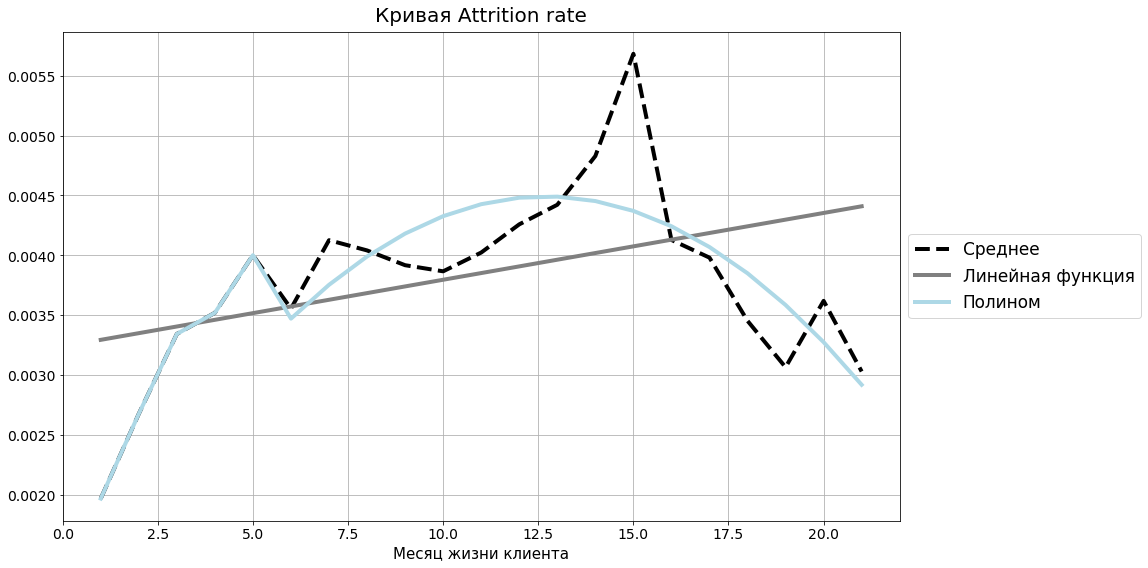

In [45]:
def polynom_approximation(df, start=1, finish=20, degree = 1):
    df_res = pd.DataFrame(df)
    df_res['Полином'] = df['Среднее']                   
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)                                                 
    df_res.loc[start:finish, 'Полином'] = linear_coeff(np.arange(start, finish+1)) 
    df_res.loc[finish+1:, 'Полином'] = linear_coeff(finish+1)                    
    return df_res

df_linear = attrition_rate_mean.query('pd_bucket == 3').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 1, 20)

# Делаем полиномиальную аппроксимацию
df_polynom = polynom_approximation(df_linear, 6,20,2)

# Строим получившиеся графики вместе
plt.figure(figsize=(15, 9))
df_polynom['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_polynom['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_polynom['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Повышаем start

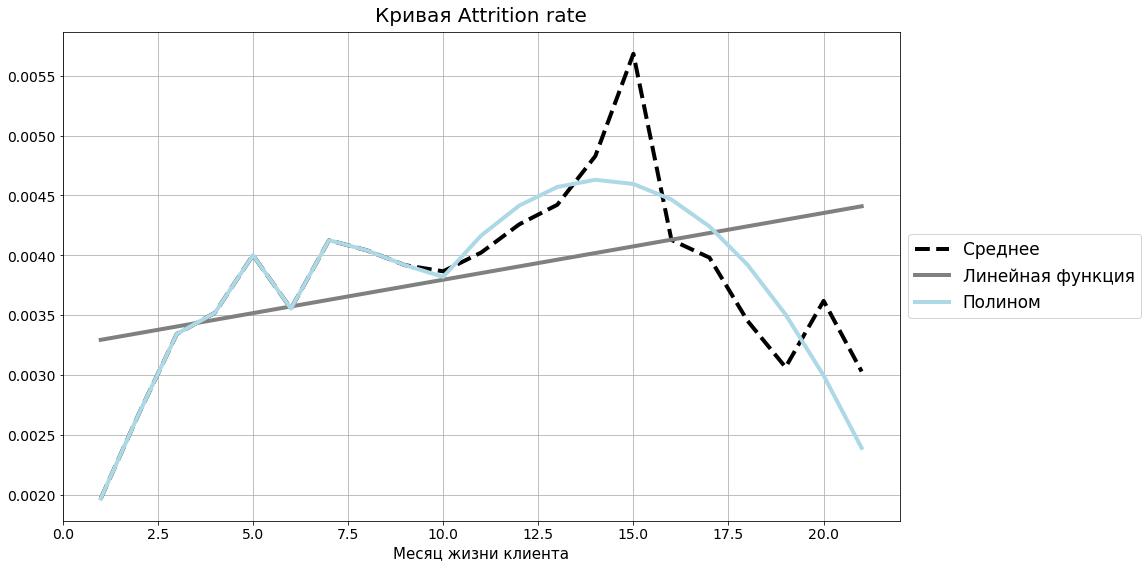

In [46]:
df_linear = attrition_rate_mean.query('pd_bucket == 3').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 1, 20)

# Делаем полиномиальную аппроксимацию
df_polynom = polynom_approximation(df_linear, 10,20,2)

# Строим получившиеся графики вместе
plt.figure(figsize=(15, 9))
df_polynom['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_polynom['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_polynom['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

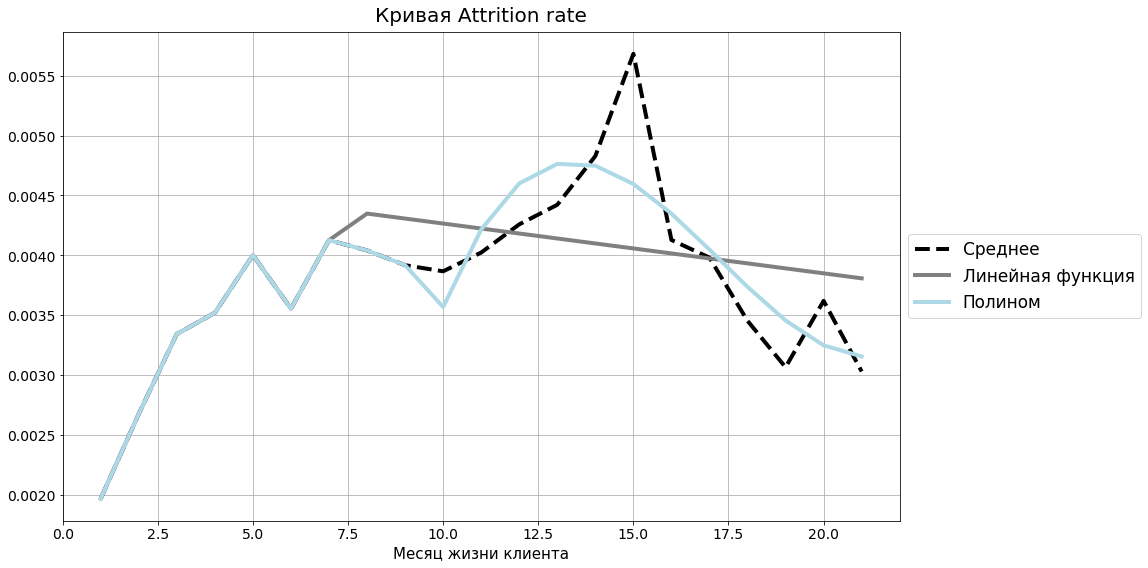

In [47]:
df_linear = attrition_rate_mean.query('pd_bucket == 3').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 8, 20)

# Делаем полиномиальную аппроксимацию
df_polynom = polynom_approximation(df_linear, 10,20,3)

# Строим получившиеся графики вместе
plt.figure(figsize=(15, 9))
df_polynom['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_polynom['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_polynom['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Посмотрим результат на всех бакетах

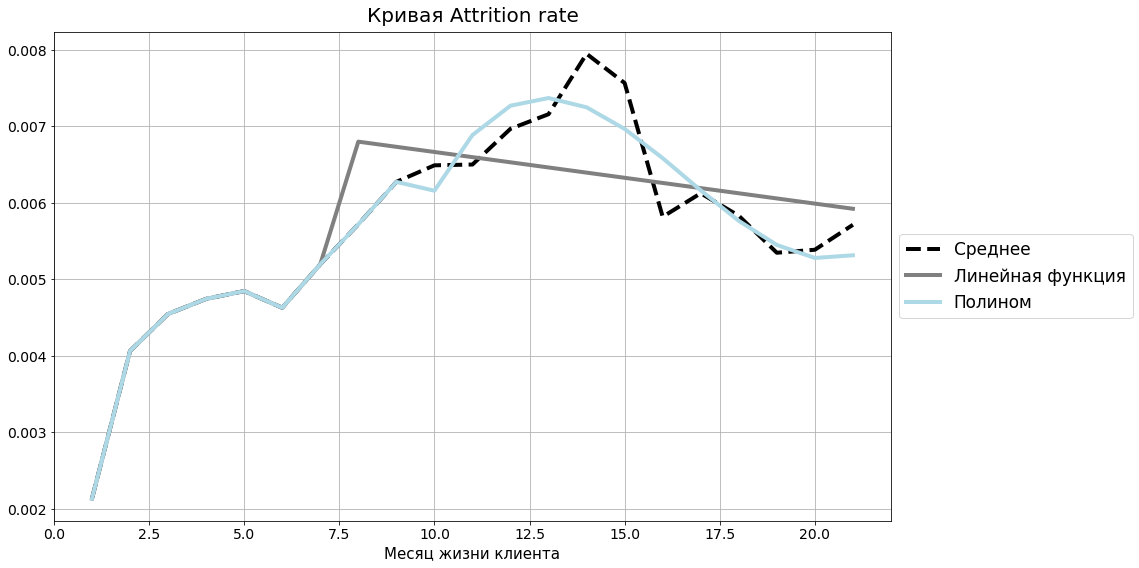

In [48]:
df_linear = attrition_rate_mean.query('pd_bucket == 1').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 8, 20)

# Делаем полиномиальную аппроксимацию
df_polynom = polynom_approximation(df_linear, 10,20,3)

# Строим получившиеся графики вместе
plt.figure(figsize=(15, 9))
df_polynom['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_polynom['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_polynom['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

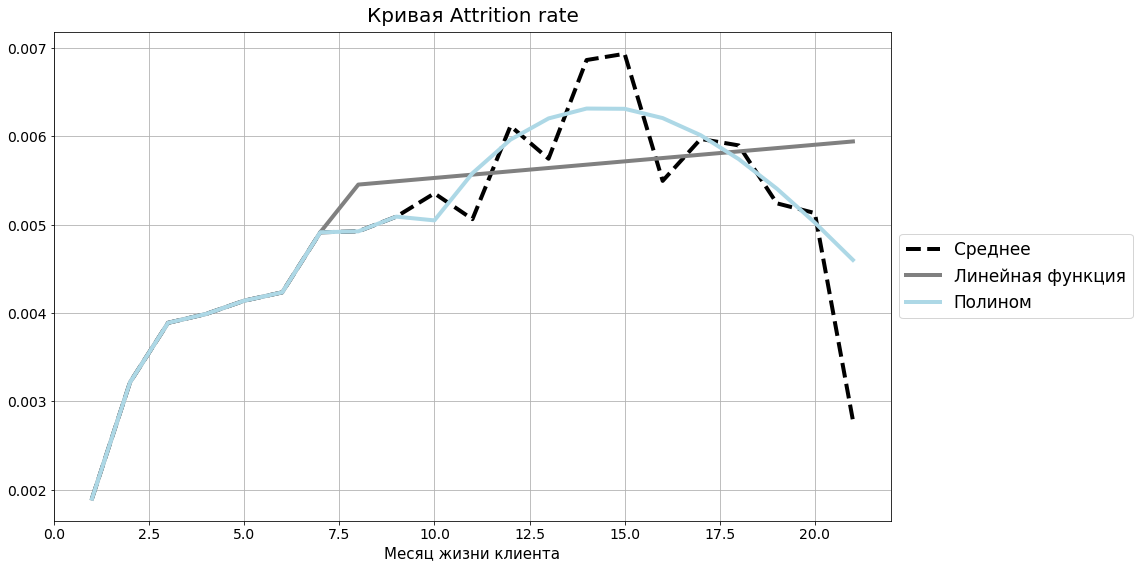

In [49]:
df_linear = attrition_rate_mean.query('pd_bucket == 2').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 8, 20)

# Делаем полиномиальную аппроксимацию
df_polynom = polynom_approximation(df_linear, 10,20,3)

# Строим получившиеся графики вместе
plt.figure(figsize=(15, 9))
df_polynom['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_polynom['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_polynom['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

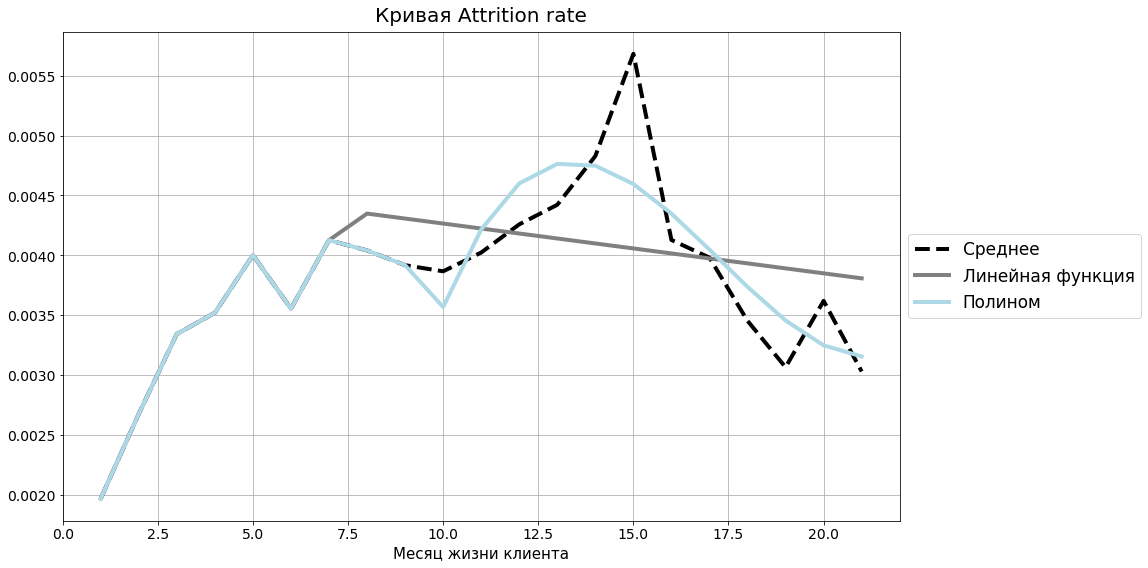

In [50]:
df_linear = attrition_rate_mean.query('pd_bucket == 3').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 8, 20)

# Делаем полиномиальную аппроксимацию
df_polynom = polynom_approximation(df_linear, 10,20,3)

# Строим получившиеся графики вместе
plt.figure(figsize=(15, 9))
df_polynom['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_polynom['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_polynom['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Построим скользящее среднее 

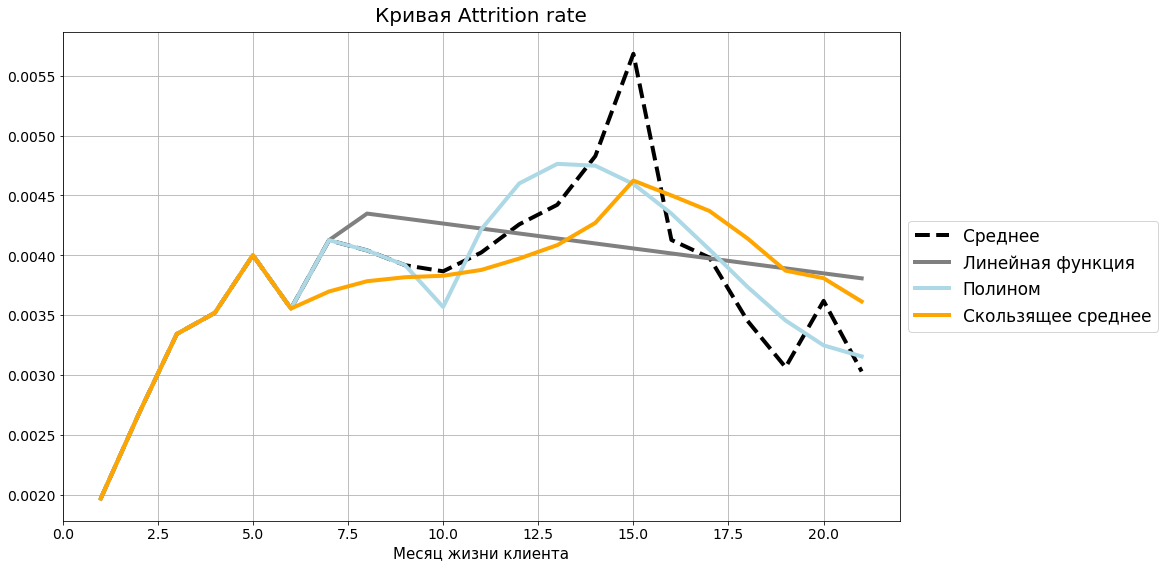

In [51]:
def exponential_smoothing(df, start, finish, alpha):
    df_res = pd.DataFrame(df)
    result = [df_res.loc[i,'Среднее'] for i in np.arange(1,start+1)]                              # Начальные значения копируем
    for n in range(start, len(df_res['Среднее'])): 
        result.append(float(alpha * df_res.loc[n + 1, 'Среднее'] + (1 - alpha) * result[n-1]))    # Делаем сглаживание
    df_res['Скользящее среднее'] = result
    return df_res

df_linear = attrition_rate_mean.query('pd_bucket == 3').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 8, 20)

# Делаем полиномиальную аппроксимацию
df_polynom = polynom_approximation(df_linear, 10,20,3)

# Строим экспоненциальное скользящее среднее с alpha = 0.25
df_smooth = exponential_smoothing(df_polynom, 6,21, 0.25)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Исследуем скользящее среднее

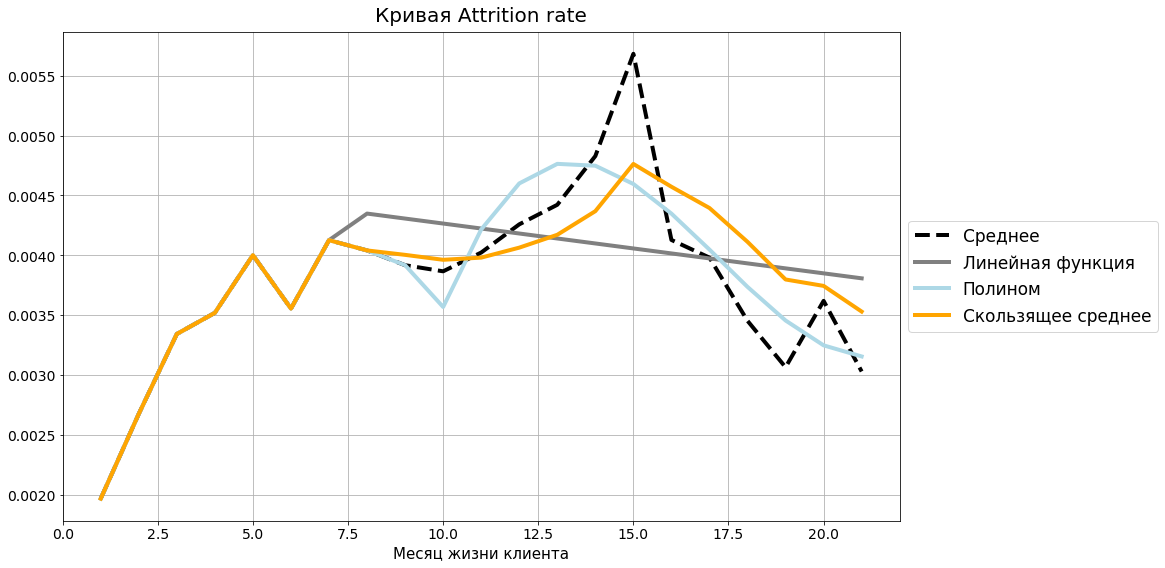

In [52]:
df_linear = attrition_rate_mean.query('pd_bucket == 3').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 8, 20)

# Делаем полиномиальную аппроксимацию
df_polynom = polynom_approximation(df_linear, 10,20,3)

# Строим экспоненциальное скользящее среднее с alpha = 0.25
df_smooth = exponential_smoothing(df_polynom, 8,21, 0.3)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)
third = df_smooth['Скользящее среднее']
third_poly = df_smooth['Полином']

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

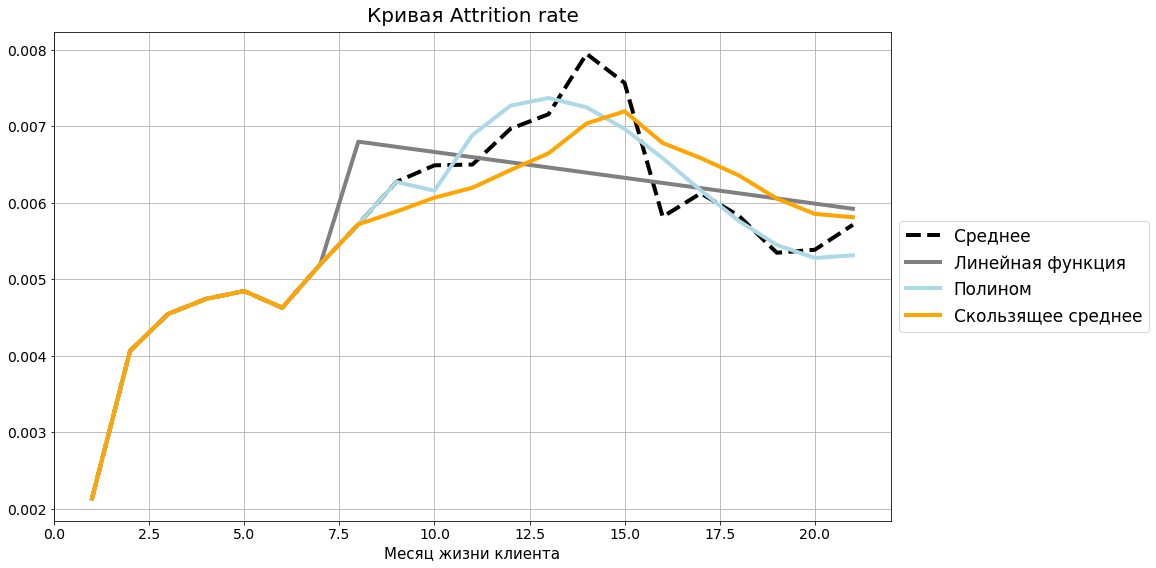

In [53]:
df_linear = attrition_rate_mean.query('pd_bucket == 1').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 8, 20)

# Делаем полиномиальную аппроксимацию
df_polynom = polynom_approximation(df_linear, 10,20,3)

# Строим экспоненциальное скользящее среднее с alpha = 0.25
df_smooth = exponential_smoothing(df_polynom, 8,21, 0.3)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)
first = df_smooth['Скользящее среднее']
first_poly = df_smooth['Полином']

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

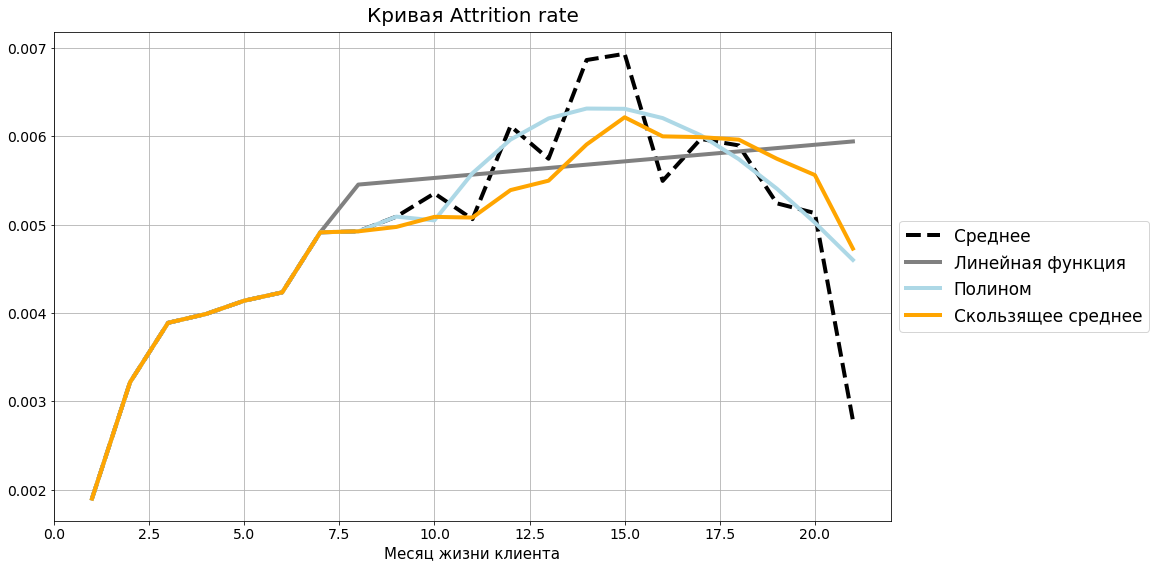

In [54]:
df_linear = attrition_rate_mean.query('pd_bucket == 2').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 8, 20)

# Делаем полиномиальную аппроксимацию
df_polynom = polynom_approximation(df_linear, 10,20,3)

# Строим экспоненциальное скользящее среднее с alpha = 0.25
df_smooth = exponential_smoothing(df_polynom, 8,21, 0.3)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)
second = df_smooth['Скользящее среднее']
second_poly = df_smooth['Полином']

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Attrition rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Итоговый прогноз

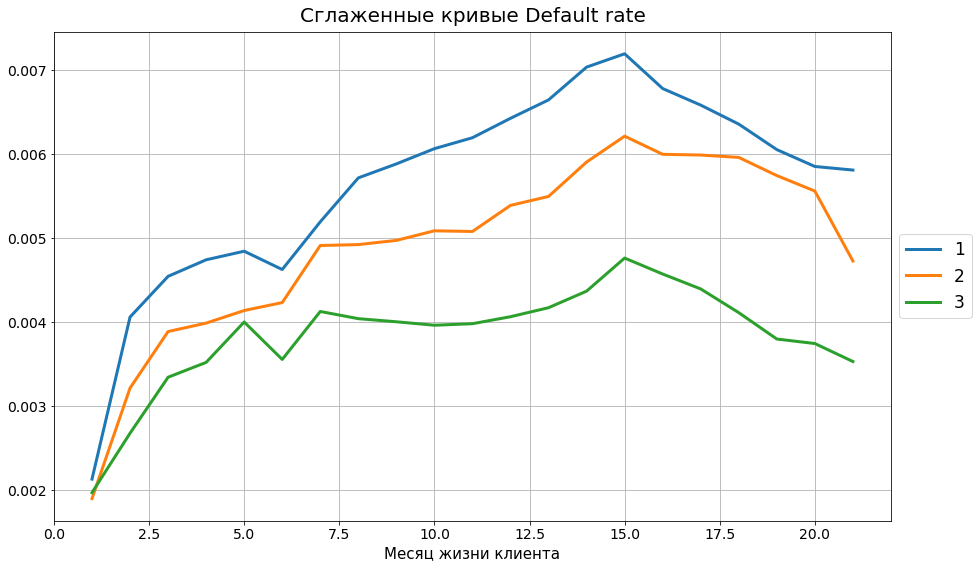

In [55]:
# Строим получившиеся графики

buckets = df['pd_bucket'].drop_duplicates()
df_smooth_result = pd.DataFrame()
df_smooth_result[1] = first
df_smooth_result[2] = second
df_smooth_result[3] = third

# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые Default rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Вывод: скользящее среднее описывает кривую наиболее логичным способом

In [56]:
def my_approximation(df, start=1, finish=20):
    #написал выше через скользящее среднее
    pass
    
#df_approx = my_approximation(df, my_start, my_finish)
def plot_approximated_curve():
    # Строим получившиеся графики

    buckets = df['pd_bucket'].drop_duplicates()
    df_smooth_result = pd.DataFrame()
    df_smooth_result[1] = first
    df_smooth_result[2] = second
    df_smooth_result[3] = third

    # Строим итоговый график
    df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Сглаженные кривые Default rate", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

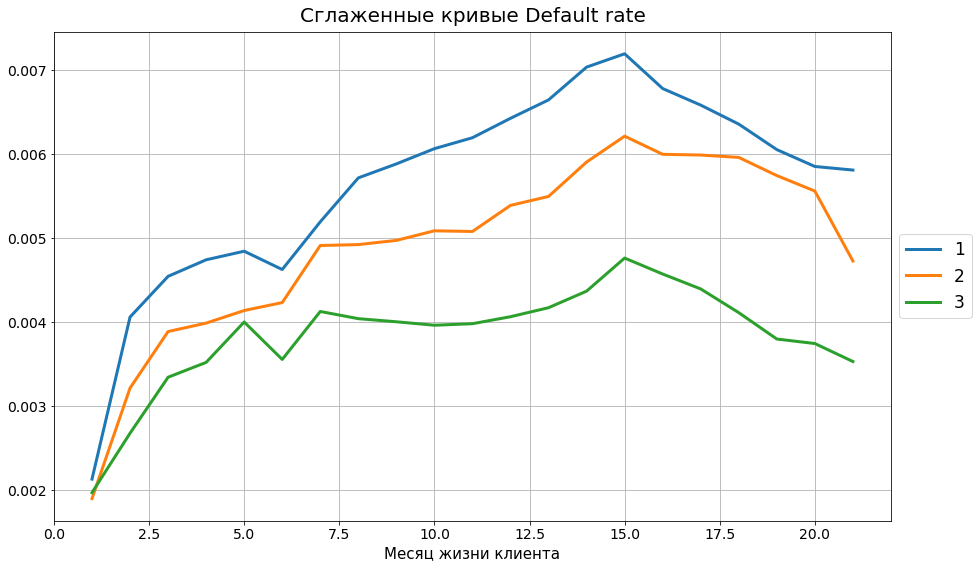

In [57]:
plot_approximated_curve()

## Построим кривые утилизации лимита для активных счетов без просрочки

#### Задание 6
* Построить разделение кривой от PD, дохода, канала и параметра X на примере одного поколения, выбрать наилучший параметр (***4 балла***)
* Поразмышлять, чем может оказаться параметр X (***1 балл***)

### По всем клиентам

In [58]:
def utilization_by_bucket(df, bucket):
# Your code goes here
    # Винтажи

    utilization_data = df.query(''' generation_month == '2017-01-01' ''')\
        .groupby([bucket, "statement_num"])\
        .agg({"balance":np.sum, "current_limit_amt":np.sum})\
        .eval('utilization = balance / current_limit_amt', inplace=False)

    # Считаем среднее

    utilization_mean = utilization_data.groupby(['statement_num'])\
        .agg({'utilization':np.mean})\
        .rename(columns = {'utilization':'Среднее'})
    
    vintages_graph = utilization_data.unstack(bucket)\
            ['utilization']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    (utilization_mean
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая утилизации лимита по счетам без просрочки", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

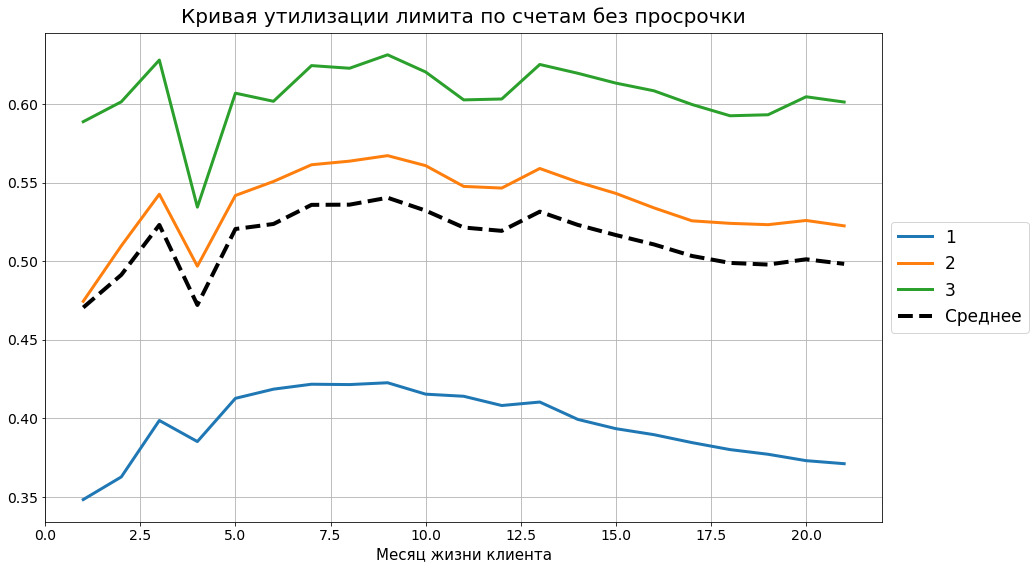

In [59]:
utilization_by_bucket(df, pd_bucket)

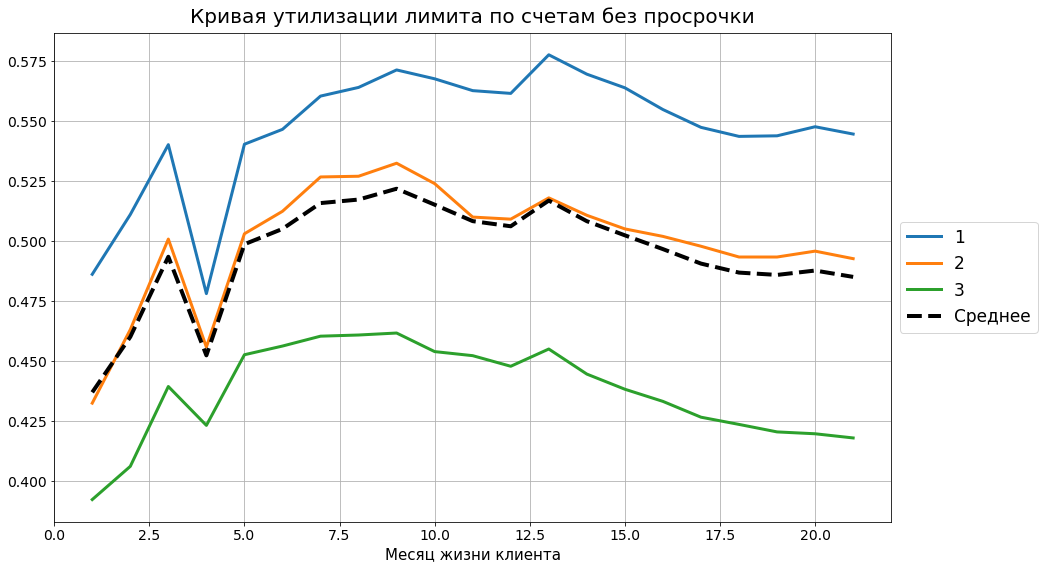

In [60]:
utilization_by_bucket(df, income_bucket)

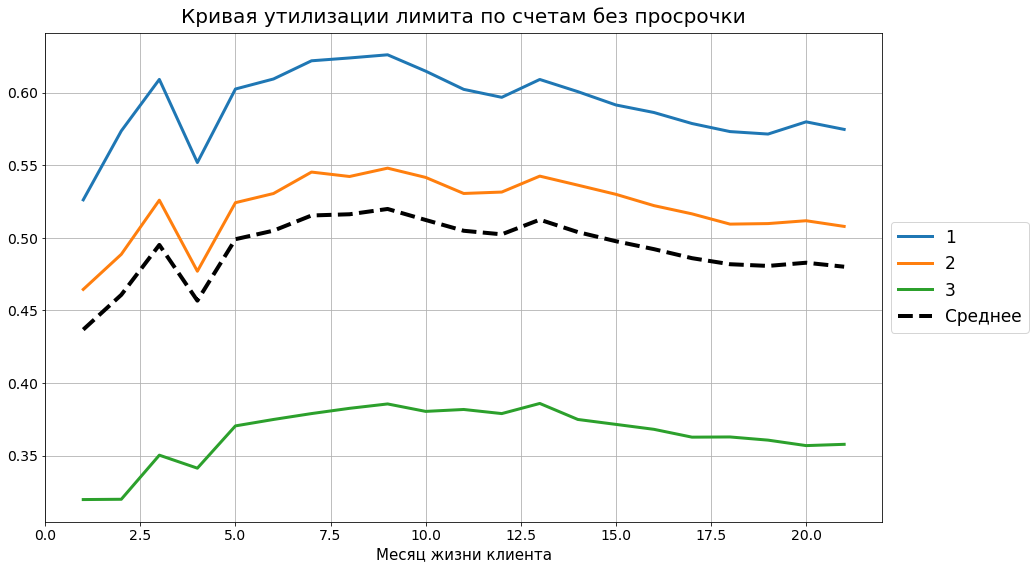

In [61]:
utilization_by_bucket(df, x_parameter_bucket)

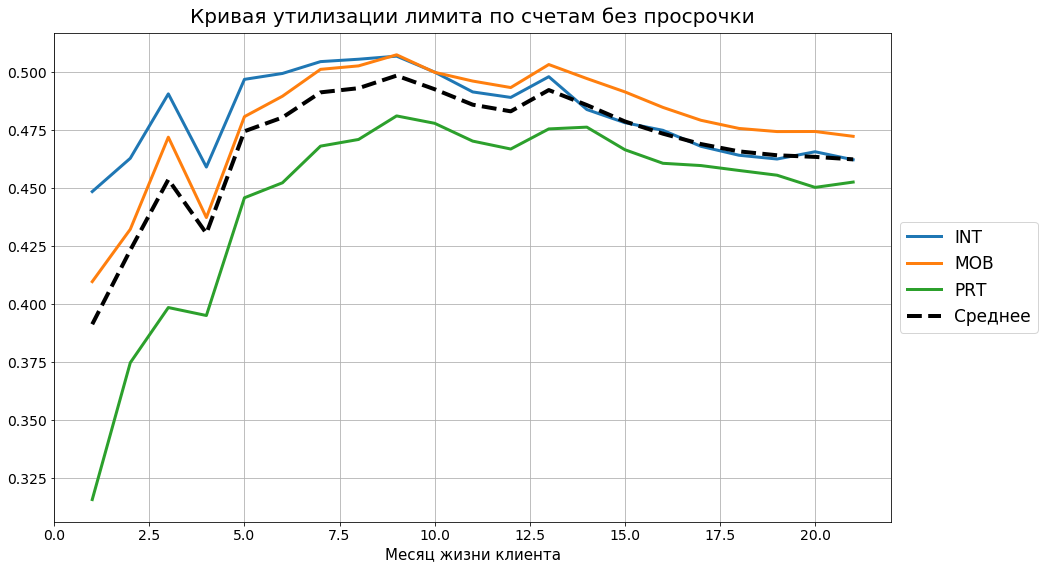

In [62]:
utilization_by_bucket(df, channel)

### Построим винтажи утилизации по активным счетам без просрочки

In [63]:
def utilization_by_bucket_CUR(df, bucket):
# Your code goes here
    # Винтажи

    utilization_data = df.query(''' model_segment == 'CUR' ''') \
        .query(''' generation_month == '2017-01-01' ''')\
        .groupby([bucket, "statement_num"])\
        .agg({"balance":np.sum, "current_limit_amt":np.sum})\
        .eval('utilization = balance / current_limit_amt', inplace=False)

    # Считаем среднее

    utilization_mean = utilization_data.groupby(['statement_num'])\
        .agg({'utilization':np.mean})\
        .rename(columns = {'utilization':'Среднее'})
    
    vintages_graph = utilization_data.unstack(bucket)\
            ['utilization']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    (utilization_mean
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая утилизации лимита по счетам без просрочки", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

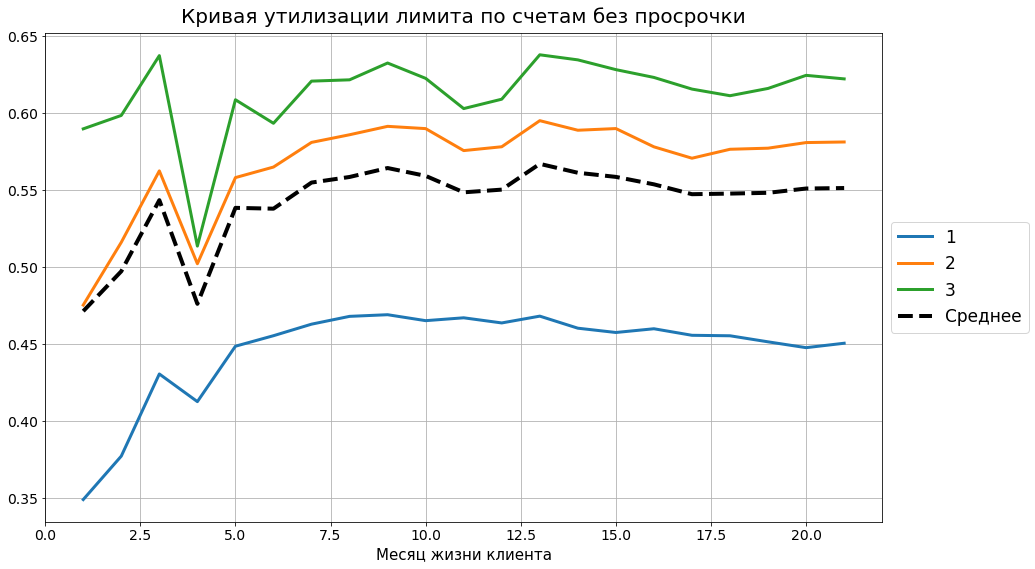

In [64]:
utilization_by_bucket_CUR(df, pd_bucket)

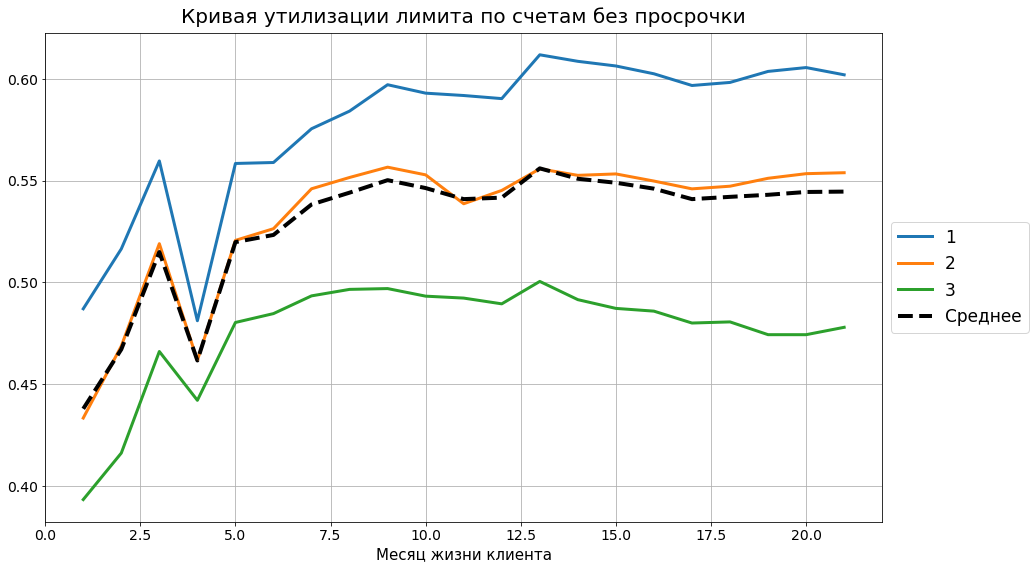

In [65]:
utilization_by_bucket_CUR(df, income_bucket)

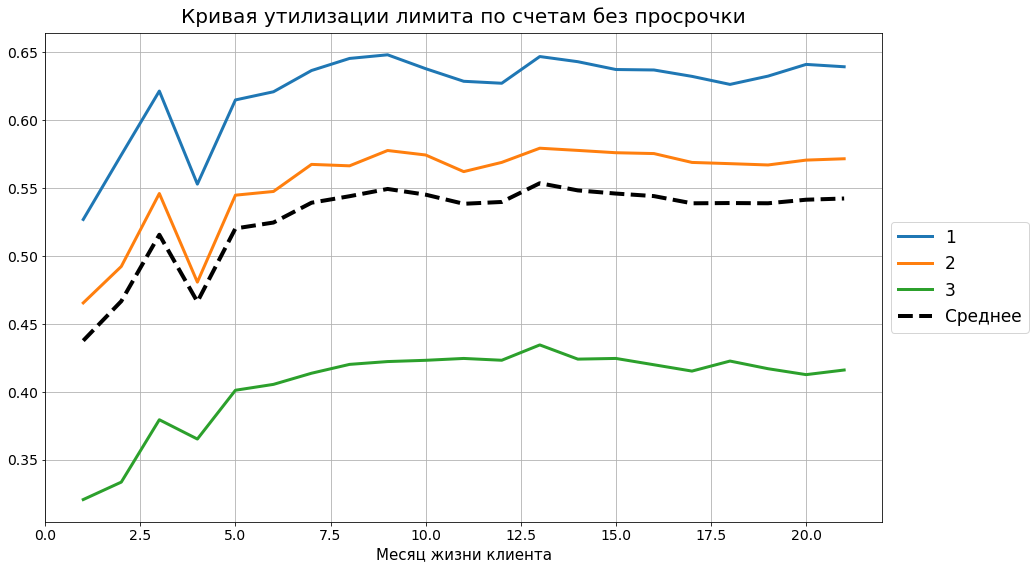

In [66]:
utilization_by_bucket_CUR(df, x_parameter_bucket)

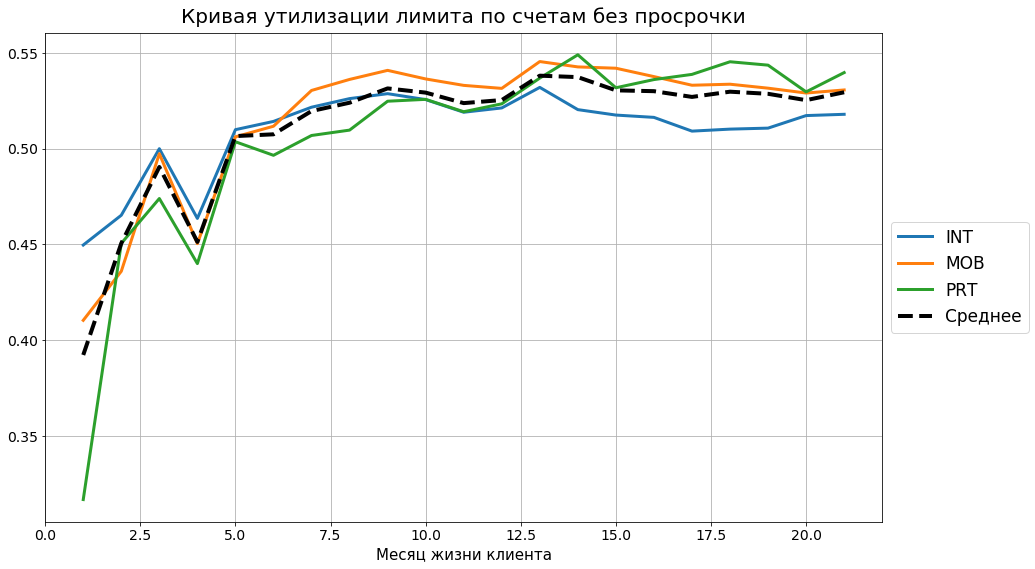

In [67]:
utilization_by_bucket_CUR(df, channel)

### Вывод: Параметр X кажется наилучшим, проверим другие поколения

- Далее посмотрим на поведение на других поколениях по всем клиентам
- (Аналогично можно по активным)
- Наилучшим параметром кажется параметр X

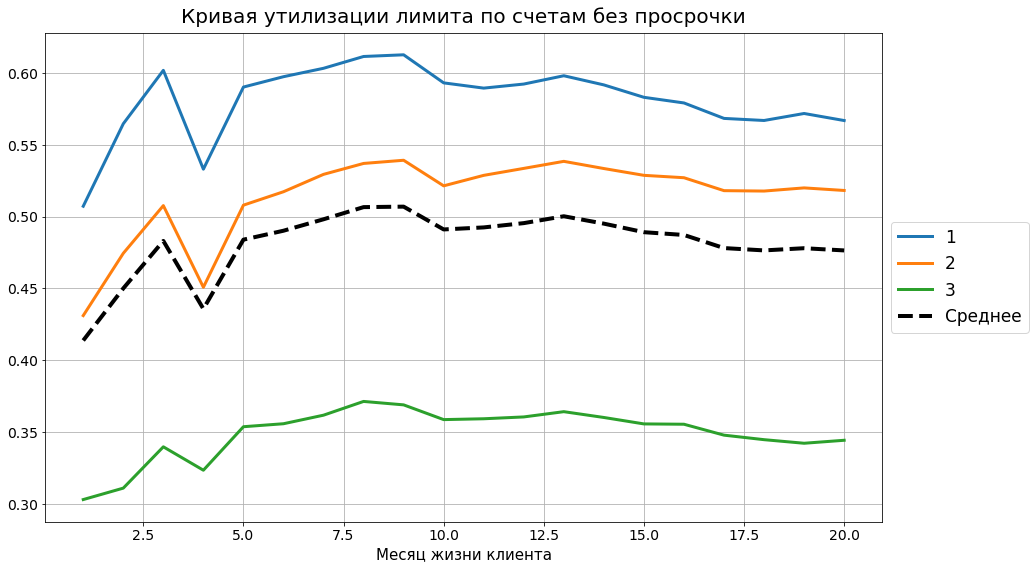

In [68]:
def utilization_by_bucket(df, bucket):
# Your code goes here
    # Винтажи

    utilization_data = df.query(''' generation_month == '2017-02-01' ''')\
        .groupby([bucket, "statement_num"])\
        .agg({"balance":np.sum, "current_limit_amt":np.sum})\
        .eval('utilization = balance / current_limit_amt', inplace=False)

    # Считаем среднее

    utilization_mean = utilization_data.groupby(['statement_num'])\
        .agg({'utilization':np.mean})\
        .rename(columns = {'utilization':'Среднее'})
    
    vintages_graph = utilization_data.unstack(bucket)\
            ['utilization']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    (utilization_mean
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая утилизации лимита по счетам без просрочки", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

utilization_by_bucket(df, x_parameter_bucket)

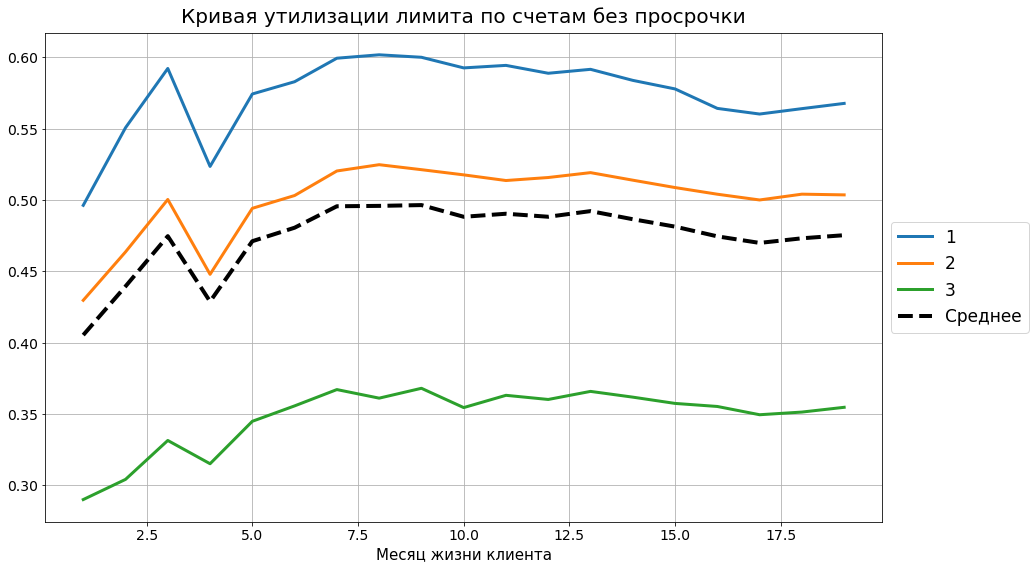

In [69]:
def utilization_by_bucket(df, bucket):
# Your code goes here
    # Винтажи

    utilization_data = df.query(''' generation_month == '2017-03-01' ''')\
        .groupby([bucket, "statement_num"])\
        .agg({"balance":np.sum, "current_limit_amt":np.sum})\
        .eval('utilization = balance / current_limit_amt', inplace=False)

    # Считаем среднее

    utilization_mean = utilization_data.groupby(['statement_num'])\
        .agg({'utilization':np.mean})\
        .rename(columns = {'utilization':'Среднее'})
    
    vintages_graph = utilization_data.unstack(bucket)\
            ['utilization']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    (utilization_mean
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая утилизации лимита по счетам без просрочки", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

utilization_by_bucket(df, x_parameter_bucket)

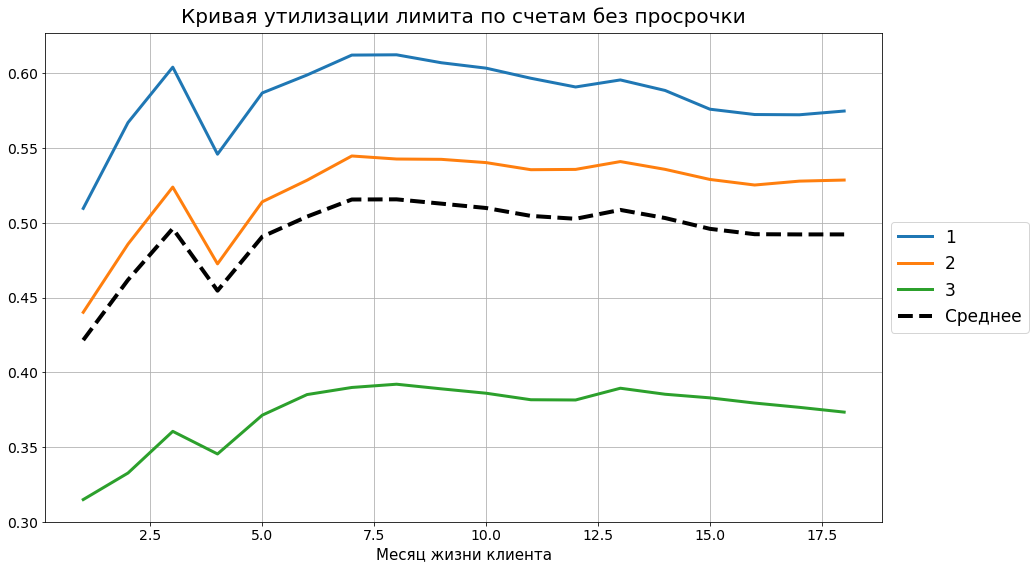

In [70]:
def utilization_by_bucket(df, bucket):
# Your code goes here
    # Винтажи

    utilization_data = df.query(''' generation_month == '2017-04-01' ''')\
        .groupby([bucket, "statement_num"])\
        .agg({"balance":np.sum, "current_limit_amt":np.sum})\
        .eval('utilization = balance / current_limit_amt', inplace=False)

    # Считаем среднее

    utilization_mean = utilization_data.groupby(['statement_num'])\
        .agg({'utilization':np.mean})\
        .rename(columns = {'utilization':'Среднее'})
    
    vintages_graph = utilization_data.unstack(bucket)\
            ['utilization']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    (utilization_mean
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая утилизации лимита по счетам без просрочки", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

utilization_by_bucket(df, x_parameter_bucket)

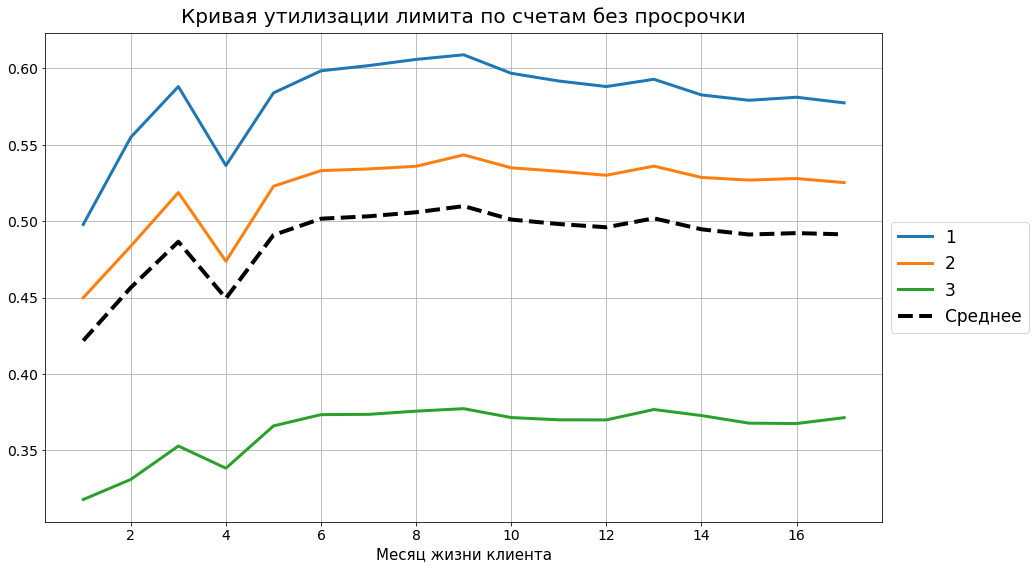

In [71]:
def utilization_by_bucket(df, bucket):
# Your code goes here
    # Винтажи

    utilization_data = df.query(''' generation_month == '2017-05-01' ''')\
        .groupby([bucket, "statement_num"])\
        .agg({"balance":np.sum, "current_limit_amt":np.sum})\
        .eval('utilization = balance / current_limit_amt', inplace=False)

    # Считаем среднее

    utilization_mean = utilization_data.groupby(['statement_num'])\
        .agg({'utilization':np.mean})\
        .rename(columns = {'utilization':'Среднее'})
    
    vintages_graph = utilization_data.unstack(bucket)\
            ['utilization']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    (utilization_mean
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая утилизации лимита по счетам без просрочки", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

utilization_by_bucket(df, x_parameter_bucket)

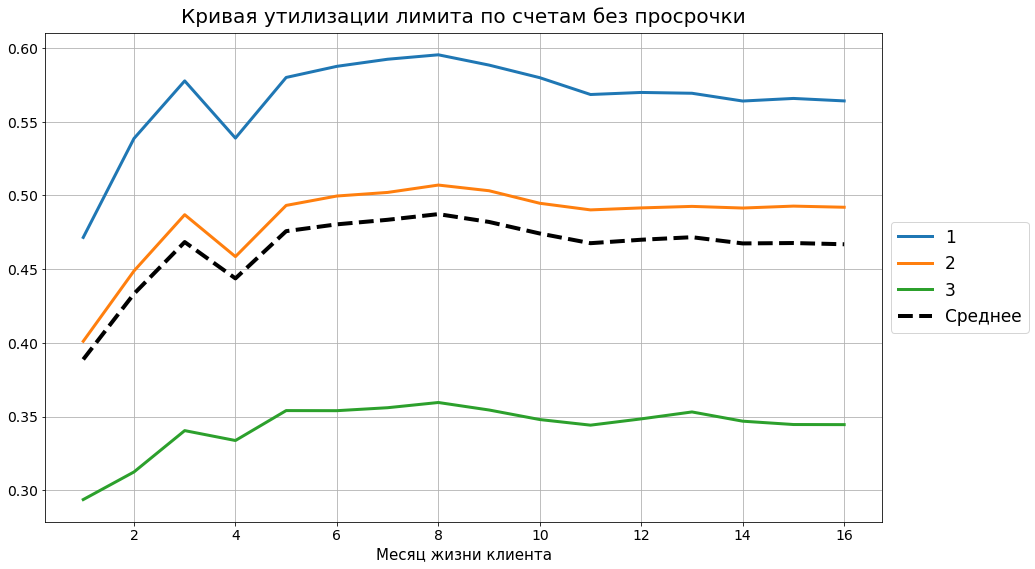

In [72]:
def utilization_by_bucket(df, bucket):
# Your code goes here
    # Винтажи

    utilization_data = df.query(''' generation_month == '2017-06-01' ''')\
        .groupby([bucket, "statement_num"])\
        .agg({"balance":np.sum, "current_limit_amt":np.sum})\
        .eval('utilization = balance / current_limit_amt', inplace=False)

    # Считаем среднее

    utilization_mean = utilization_data.groupby(['statement_num'])\
        .agg({'utilization':np.mean})\
        .rename(columns = {'utilization':'Среднее'})
    
    vintages_graph = utilization_data.unstack(bucket)\
            ['utilization']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    (utilization_mean
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая утилизации лимита по счетам без просрочки", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

utilization_by_bucket(df, x_parameter_bucket)

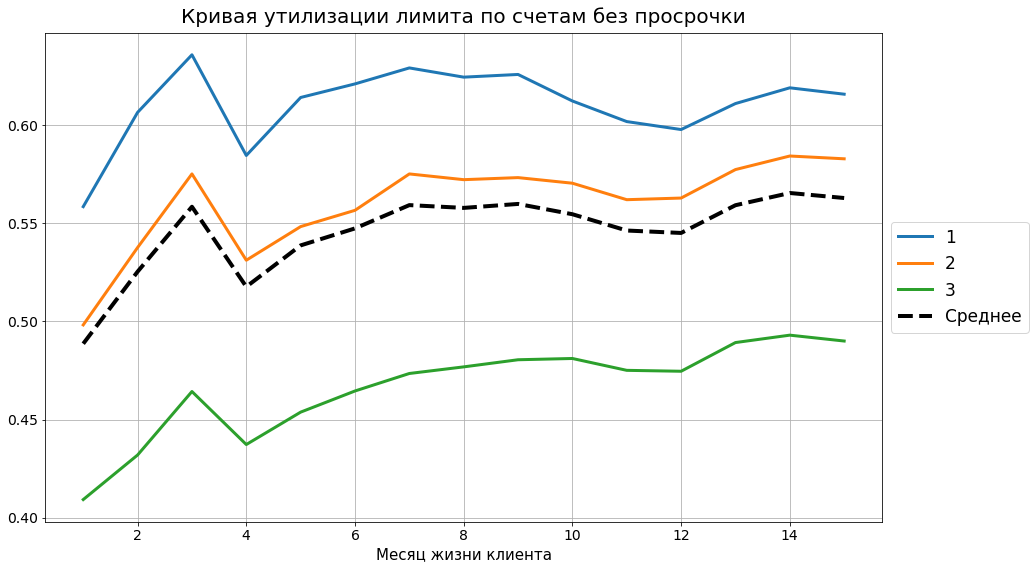

In [73]:
def utilization_by_bucket(df, bucket):
# Your code goes here
    # Винтажи

    utilization_data = df.query(''' generation_month == '2017-07-01' ''')\
        .groupby([bucket, "statement_num"])\
        .agg({"balance":np.sum, "current_limit_amt":np.sum})\
        .eval('utilization = balance / current_limit_amt', inplace=False)

    # Считаем среднее

    utilization_mean = utilization_data.groupby(['statement_num'])\
        .agg({'utilization':np.mean})\
        .rename(columns = {'utilization':'Среднее'})
    
    vintages_graph = utilization_data.unstack(bucket)\
            ['utilization']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    (utilization_mean
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая утилизации лимита по счетам без просрочки", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

utilization_by_bucket(df, x_parameter_bucket)

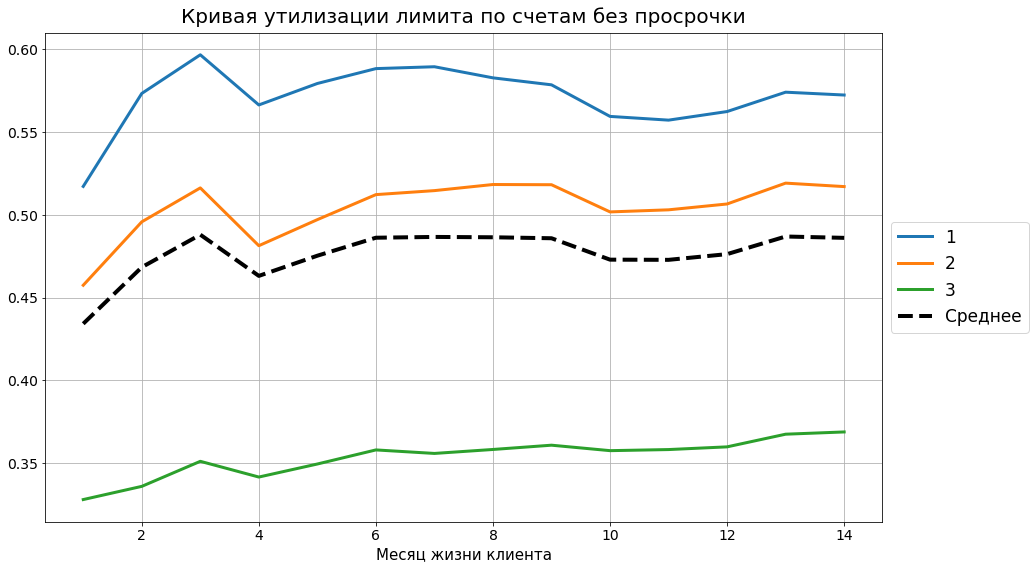

In [74]:
def utilization_by_bucket(df, bucket):
# Your code goes here
    # Винтажи

    utilization_data = df.query(''' generation_month == '2017-08-01' ''')\
        .groupby([bucket, "statement_num"])\
        .agg({"balance":np.sum, "current_limit_amt":np.sum})\
        .eval('utilization = balance / current_limit_amt', inplace=False)

    # Считаем среднее

    utilization_mean = utilization_data.groupby(['statement_num'])\
        .agg({'utilization':np.mean})\
        .rename(columns = {'utilization':'Среднее'})
    
    vintages_graph = utilization_data.unstack(bucket)\
            ['utilization']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    (utilization_mean
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая утилизации лимита по счетам без просрочки", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

utilization_by_bucket(df, x_parameter_bucket)

### Рассмотрим другие параметры по поколениям для сравнения

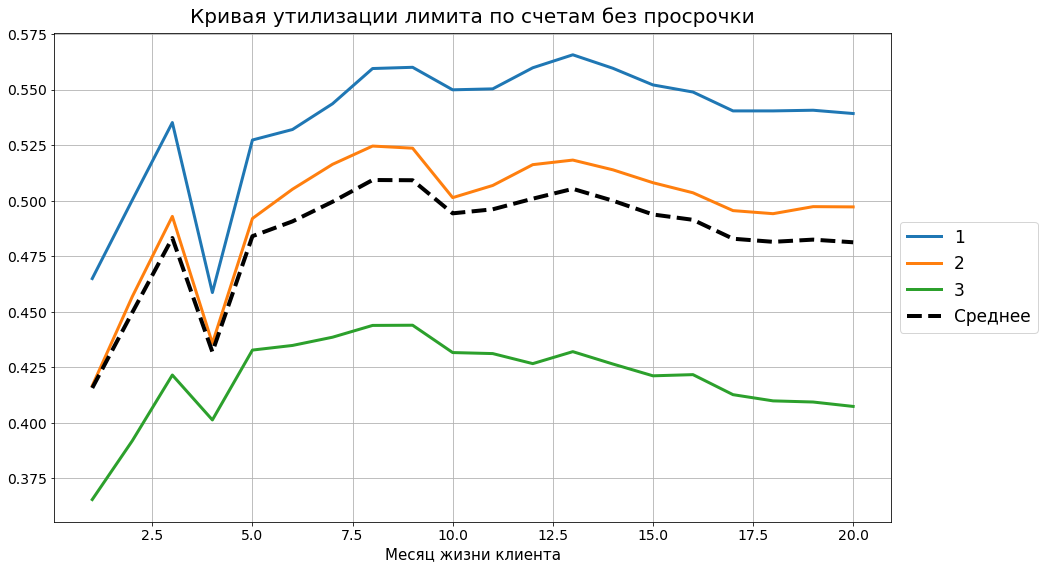

In [75]:
def utilization_by_bucket(df, bucket):
# Your code goes here
    # Винтажи

    utilization_data = df.query(''' generation_month == '2017-02-01' ''')\
        .groupby([bucket, "statement_num"])\
        .agg({"balance":np.sum, "current_limit_amt":np.sum})\
        .eval('utilization = balance / current_limit_amt', inplace=False)

    # Считаем среднее

    utilization_mean = utilization_data.groupby(['statement_num'])\
        .agg({'utilization':np.mean})\
        .rename(columns = {'utilization':'Среднее'})
    
    vintages_graph = utilization_data.unstack(bucket)\
            ['utilization']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    (utilization_mean
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая утилизации лимита по счетам без просрочки", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

utilization_by_bucket(df, income_bucket)

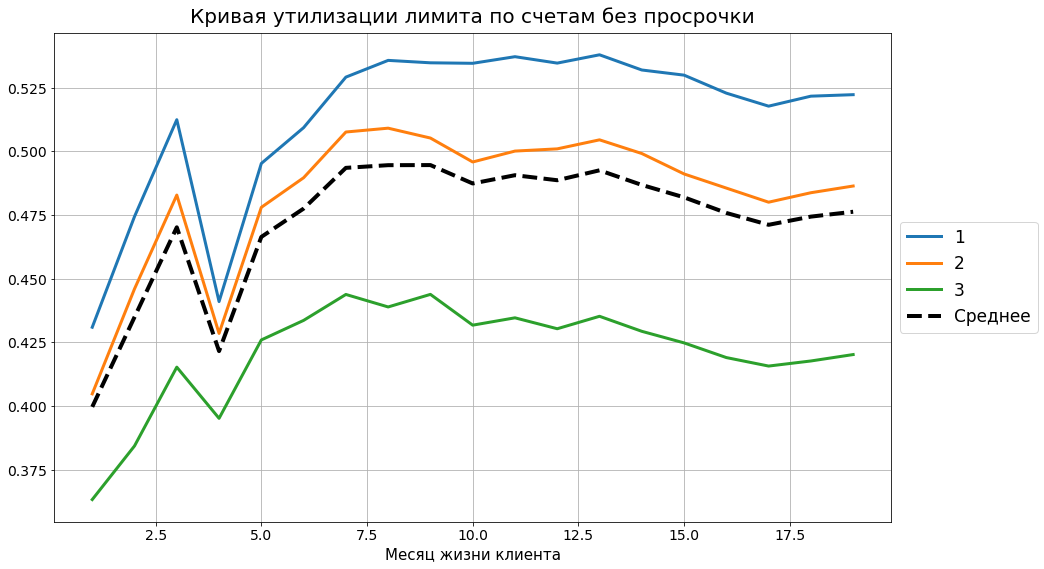

In [76]:
def utilization_by_bucket(df, bucket):
# Your code goes here
    # Винтажи

    utilization_data = df.query(''' generation_month == '2017-03-01' ''')\
        .groupby([bucket, "statement_num"])\
        .agg({"balance":np.sum, "current_limit_amt":np.sum})\
        .eval('utilization = balance / current_limit_amt', inplace=False)

    # Считаем среднее

    utilization_mean = utilization_data.groupby(['statement_num'])\
        .agg({'utilization':np.mean})\
        .rename(columns = {'utilization':'Среднее'})
    
    vintages_graph = utilization_data.unstack(bucket)\
            ['utilization']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    (utilization_mean
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая утилизации лимита по счетам без просрочки", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

utilization_by_bucket(df, income_bucket)

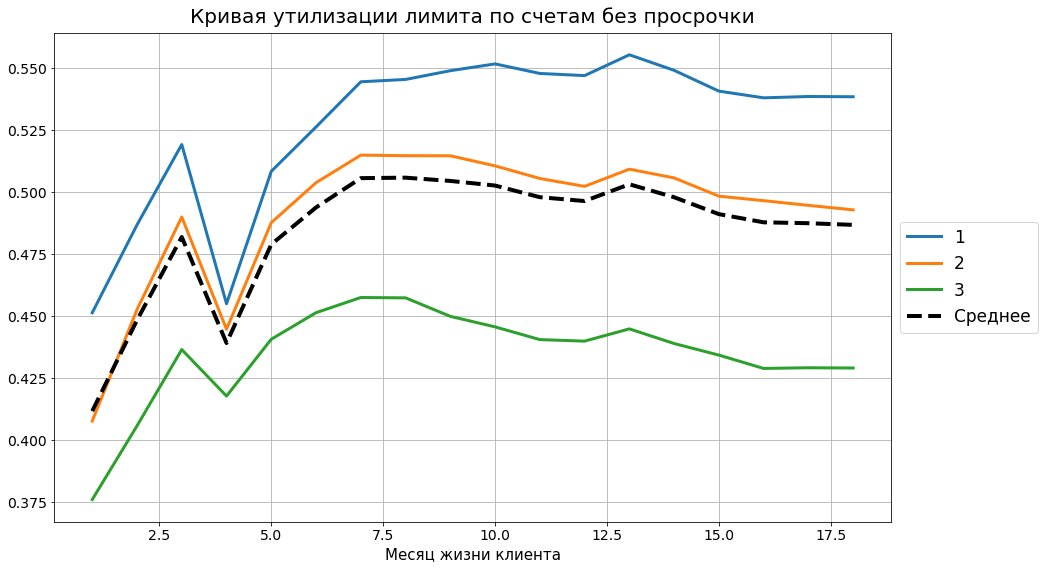

In [77]:
def utilization_by_bucket(df, bucket):
# Your code goes here
    # Винтажи

    utilization_data = df.query(''' generation_month == '2017-04-01' ''')\
        .groupby([bucket, "statement_num"])\
        .agg({"balance":np.sum, "current_limit_amt":np.sum})\
        .eval('utilization = balance / current_limit_amt', inplace=False)

    # Считаем среднее

    utilization_mean = utilization_data.groupby(['statement_num'])\
        .agg({'utilization':np.mean})\
        .rename(columns = {'utilization':'Среднее'})
    
    vintages_graph = utilization_data.unstack(bucket)\
            ['utilization']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    (utilization_mean
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая утилизации лимита по счетам без просрочки", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

utilization_by_bucket(df, income_bucket)

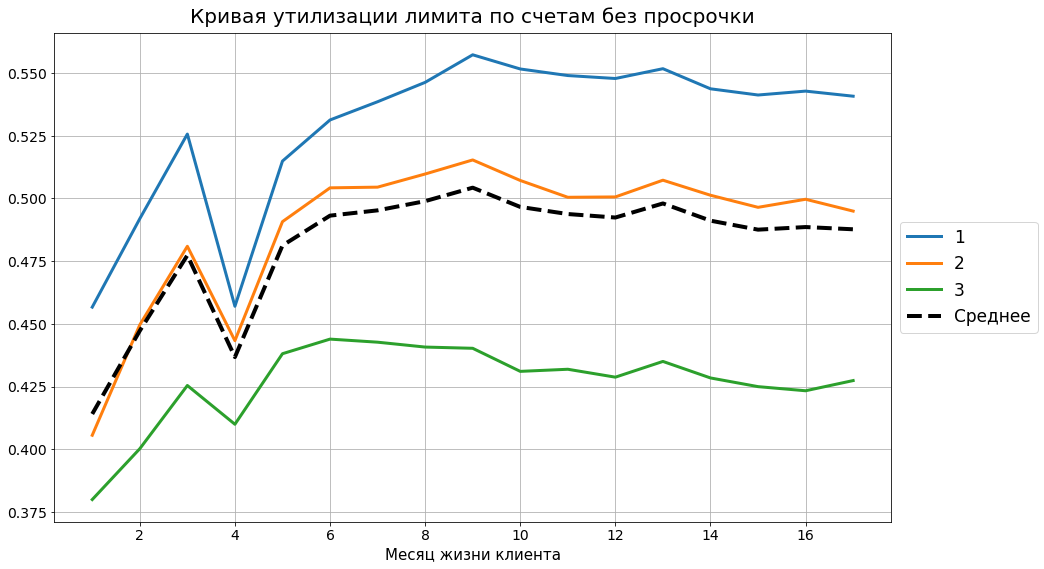

In [78]:
def utilization_by_bucket(df, bucket):
# Your code goes here
    # Винтажи

    utilization_data = df.query(''' generation_month == '2017-05-01' ''')\
        .groupby([bucket, "statement_num"])\
        .agg({"balance":np.sum, "current_limit_amt":np.sum})\
        .eval('utilization = balance / current_limit_amt', inplace=False)

    # Считаем среднее

    utilization_mean = utilization_data.groupby(['statement_num'])\
        .agg({'utilization':np.mean})\
        .rename(columns = {'utilization':'Среднее'})
    
    vintages_graph = utilization_data.unstack(bucket)\
            ['utilization']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    (utilization_mean
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая утилизации лимита по счетам без просрочки", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

utilization_by_bucket(df, income_bucket)

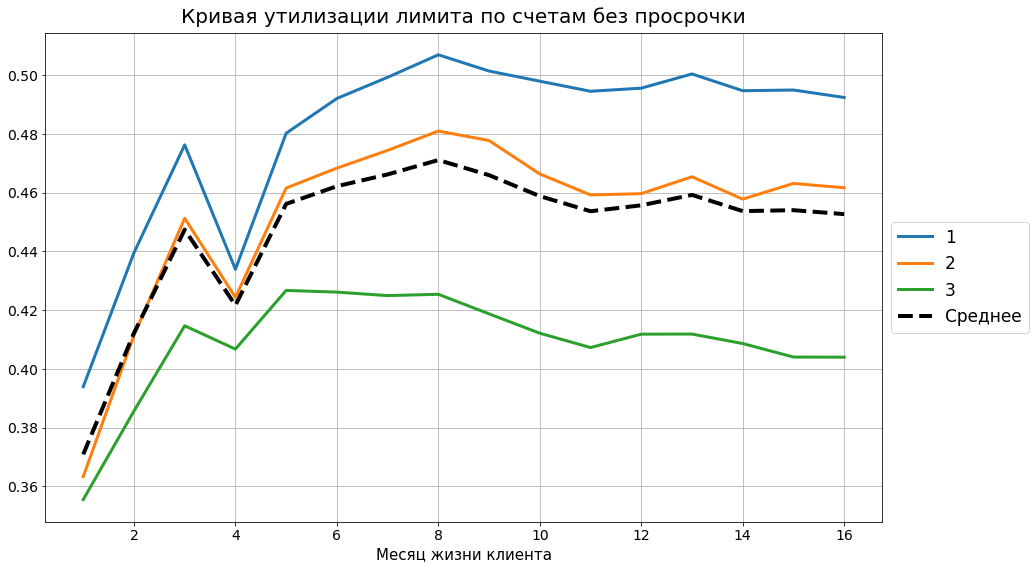

In [79]:
def utilization_by_bucket(df, bucket):
# Your code goes here
    # Винтажи

    utilization_data = df.query(''' generation_month == '2017-06-01' ''')\
        .groupby([bucket, "statement_num"])\
        .agg({"balance":np.sum, "current_limit_amt":np.sum})\
        .eval('utilization = balance / current_limit_amt', inplace=False)

    # Считаем среднее

    utilization_mean = utilization_data.groupby(['statement_num'])\
        .agg({'utilization':np.mean})\
        .rename(columns = {'utilization':'Среднее'})
    
    vintages_graph = utilization_data.unstack(bucket)\
            ['utilization']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    (utilization_mean
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая утилизации лимита по счетам без просрочки", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

utilization_by_bucket(df, income_bucket)

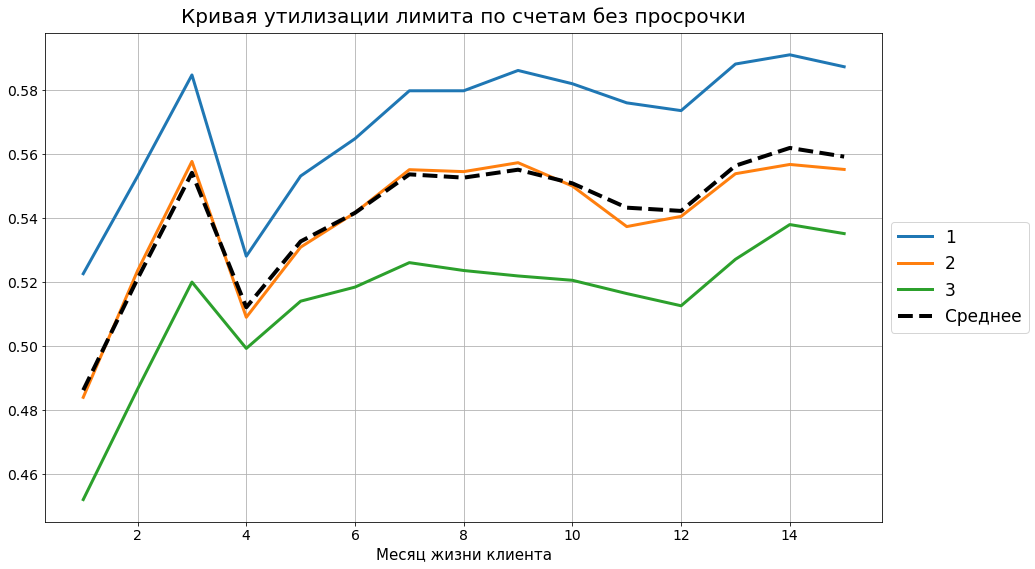

In [80]:
def utilization_by_bucket(df, bucket):
# Your code goes here
    # Винтажи

    utilization_data = df.query(''' generation_month == '2017-07-01' ''')\
        .groupby([bucket, "statement_num"])\
        .agg({"balance":np.sum, "current_limit_amt":np.sum})\
        .eval('utilization = balance / current_limit_amt', inplace=False)

    # Считаем среднее

    utilization_mean = utilization_data.groupby(['statement_num'])\
        .agg({'utilization':np.mean})\
        .rename(columns = {'utilization':'Среднее'})
    
    vintages_graph = utilization_data.unstack(bucket)\
            ['utilization']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    (utilization_mean
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая утилизации лимита по счетам без просрочки", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

utilization_by_bucket(df, income_bucket)

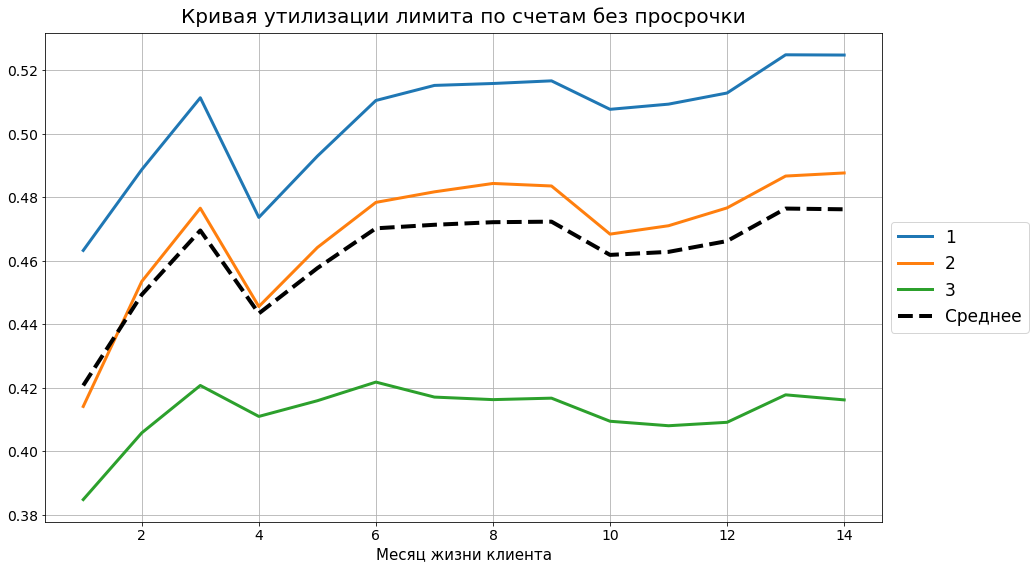

In [81]:
def utilization_by_bucket(df, bucket):
# Your code goes here
    # Винтажи

    utilization_data = df.query(''' generation_month == '2017-08-01' ''')\
        .groupby([bucket, "statement_num"])\
        .agg({"balance":np.sum, "current_limit_amt":np.sum})\
        .eval('utilization = balance / current_limit_amt', inplace=False)

    # Считаем среднее

    utilization_mean = utilization_data.groupby(['statement_num'])\
        .agg({'utilization':np.mean})\
        .rename(columns = {'utilization':'Среднее'})
    
    vintages_graph = utilization_data.unstack(bucket)\
            ['utilization']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    (utilization_mean
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая утилизации лимита по счетам без просрочки", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

utilization_by_bucket(df, income_bucket)

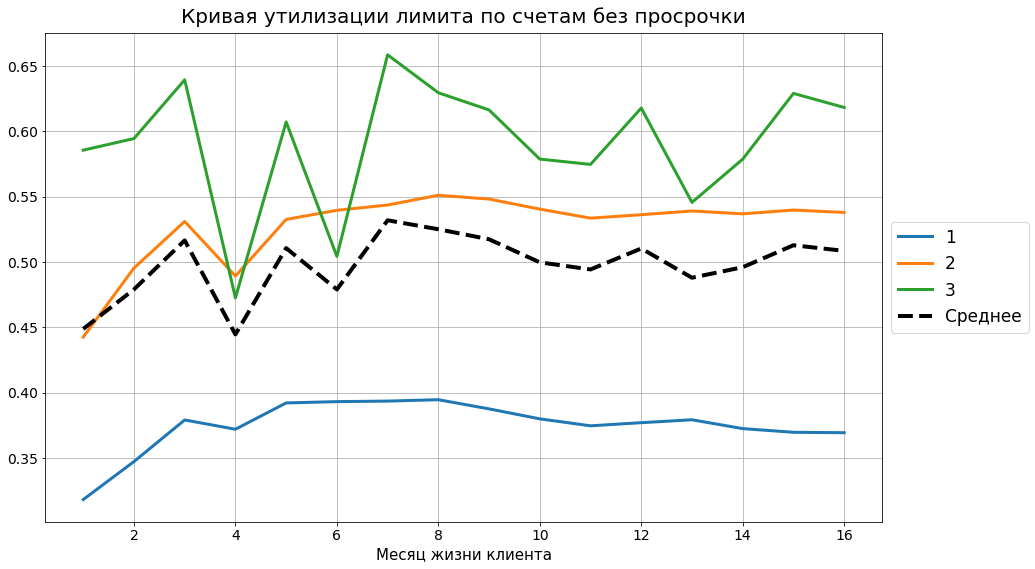

In [82]:
#PD не является наилучшим в данном случае, так как рассмотрим пример
def utilization_by_bucket(df, bucket):
# Your code goes here
    # Винтажи

    utilization_data = df.query(''' generation_month == '2017-06-01' ''')\
        .groupby([bucket, "statement_num"])\
        .agg({"balance":np.sum, "current_limit_amt":np.sum})\
        .eval('utilization = balance / current_limit_amt', inplace=False)

    # Считаем среднее

    utilization_mean = utilization_data.groupby(['statement_num'])\
        .agg({'utilization':np.mean})\
        .rename(columns = {'utilization':'Среднее'})
    
    vintages_graph = utilization_data.unstack(bucket)\
            ['utilization']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    (utilization_mean
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая утилизации лимита по счетам без просрочки", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)
utilization_by_bucket(df, pd_bucket)

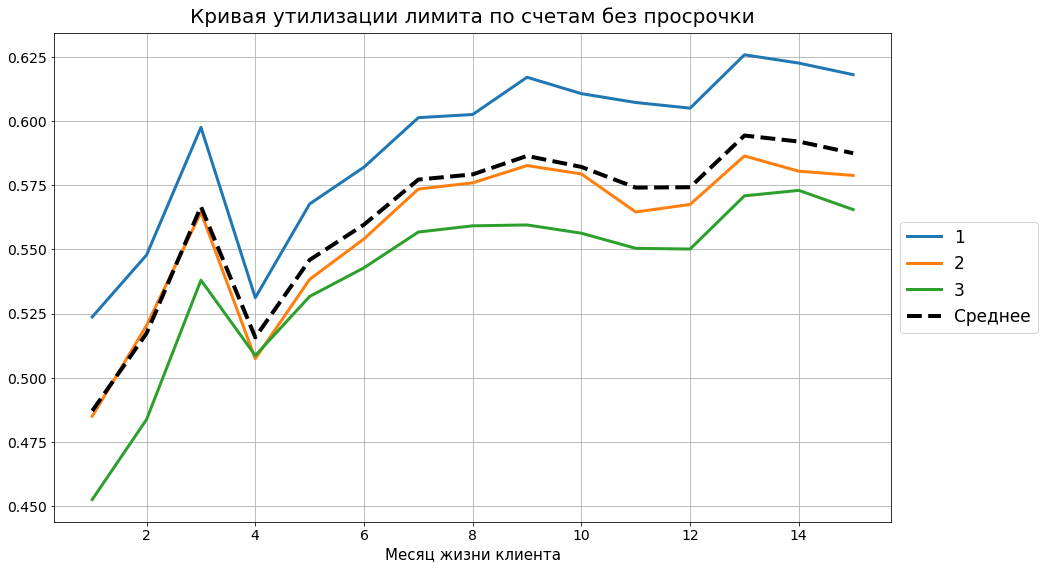

In [83]:
def utilization_by_bucket_CUR(df, bucket):
# Your code goes here
    # Винтажи

    utilization_data = df.query(''' model_segment == 'CUR' ''') \
        .query(''' generation_month == '2017-07-01' ''')\
        .groupby([bucket, "statement_num"])\
        .agg({"balance":np.sum, "current_limit_amt":np.sum})\
        .eval('utilization = balance / current_limit_amt', inplace=False)

    # Считаем среднее

    utilization_mean = utilization_data.groupby(['statement_num'])\
        .agg({'utilization':np.mean})\
        .rename(columns = {'utilization':'Среднее'})
    
    vintages_graph = utilization_data.unstack(bucket)\
            ['utilization']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    (utilization_mean
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая утилизации лимита по счетам без просрочки", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)
utilization_by_bucket_CUR(df, income_bucket)

# Вывод: 
- Наилучшим параметром является параметр X

# Чем является параметр X?

In [5]:
# df[df.x_parameter_bucket==1].head()

In [6]:
# df[df.x_parameter_bucket==2].head()

In [7]:
# df[df.x_parameter_bucket==3].head()

In [8]:
# df[df.x_parameter > 1.2].head()

In [9]:
# df[df.x_parameter > 1.4].head()

In [10]:
# df[df.x_parameter > 1.5].head()

In [11]:
# df[df.x_parameter == 1.1].head()

In [91]:
min(df.x_parameter)

0.024

In [92]:
max(df.x_parameter)

1.643

In [12]:
# df.corrwith(df.x_parameter)

In [13]:
# test = df[['current_limit_amt', 'x_parameter']]

- X параметр имеет большую положительную корреляцию с текущим кредитным лимитом
- И достаточно высокую отрицательную с PD

- Таким образом, чем выше вероятность дефолта, тем ниже Х параметр
- Чем выше максимальный кредитный лимит, тем выше Х параметр

### Вывод
- X параметр может представлять собой некий параметр стабильности выплат клиента

#### Задание 7 
* Построить винтажи кривой утилизации лимита для счетов в просрочке, объяснить странности, наблюдающиеся на них (***личная симпатия преподавателя***)

    Подсказка: утилизация определяется как отношение баланса к лимиту. 

In [95]:
# Your code goes here